# Ames Housing Dataset Analysis

# Introduction


Hello. My name is Evan Freeman. Let's analyze a housing dataset and create a model to predict housing prices of new houses that are put on the market.

Here we'll be considering the Ames Housing dataset, which is like the famous Boston Housing dataset, but better!

# Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings

warnings.filterwarnings('ignore')

# pd.options.display.max_columns = None
pd.options.display.max_rows = 56


filepath = 'D:/code/Data/house-prices-advanced-regression-techniques/'
sub_filepath = 'D:/code/Data/advanced_housing_submissions/'

housing = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

# Also, we're going to need the test ids for submission, so let's grab those
test_id = test['Id']

Note: The test data has already been split for us by Kaggle, but we MUST split off validation data (or do k-fold) as well!!! Otherwise we will overfit.  

Let's split off 20% for validation.  

Later, we'll try with k-fold validation, which should produce better results.  

It is worth pointing out that, once we've trained and validated our model, chosing the best type of model, the best features, the best hyperparameters, we should go back and train it from scratch on the entire dataset (train + valid). If we don't, we're just hamstringing our model by not using all the available data.

Also, we'll create a pipeline for all these steps. For now, we're just exploring.

In [2]:
# Train Valid Split, 80 / 20

train, valid = train_test_split(housing, test_size = .2)

# Plotting the Data

Before we start processing the data, let's visualize the data and see if we can pick out any interesting information that way.

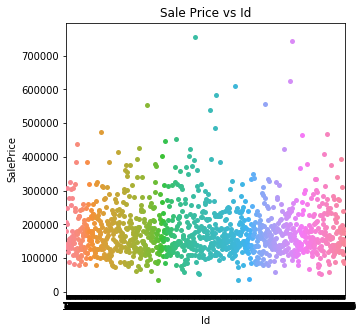

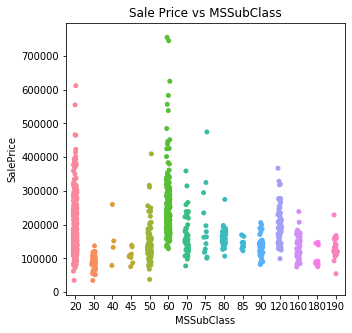

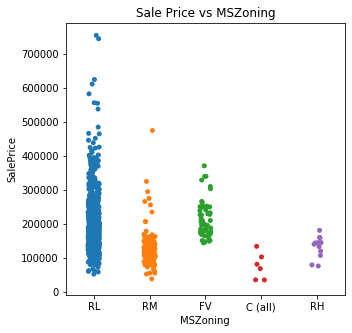

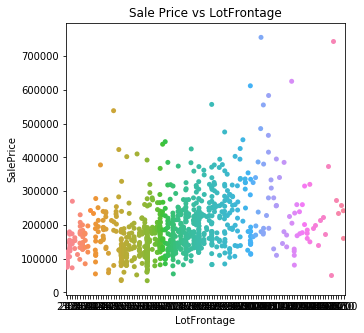

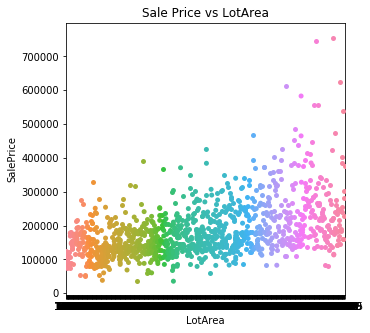

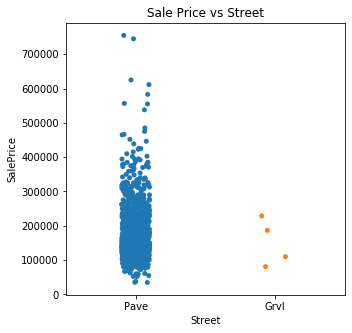

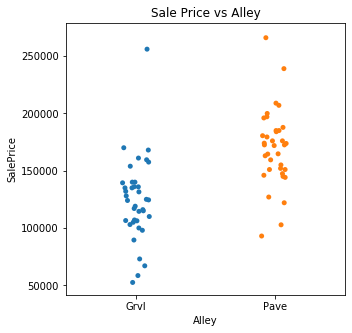

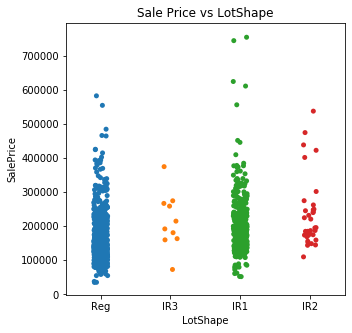

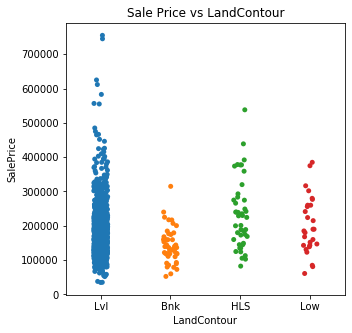

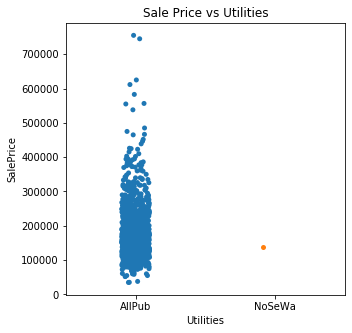

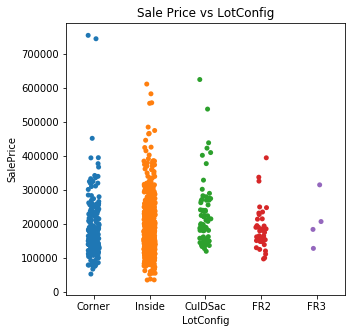

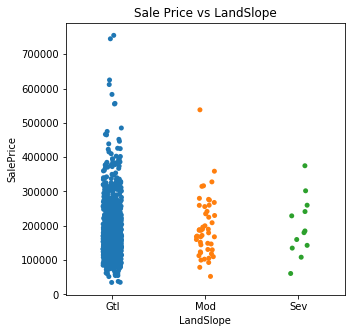

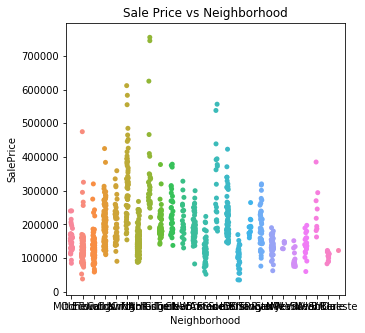

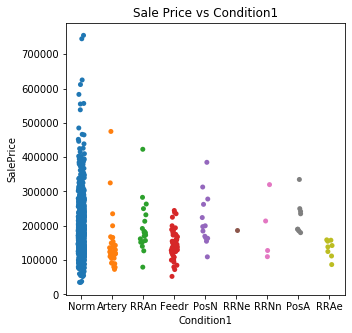

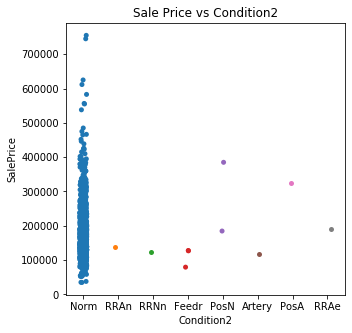

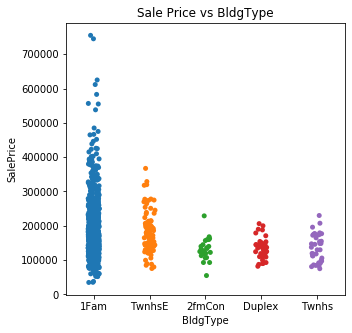

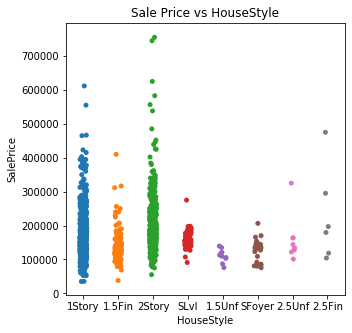

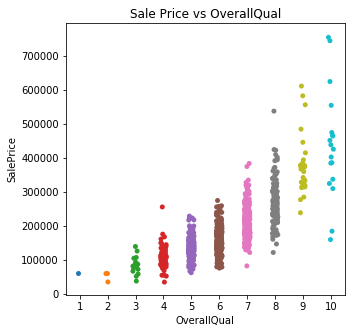

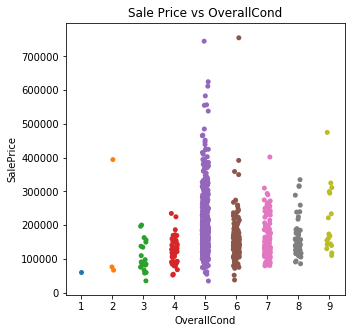

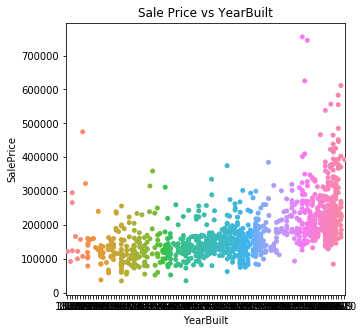

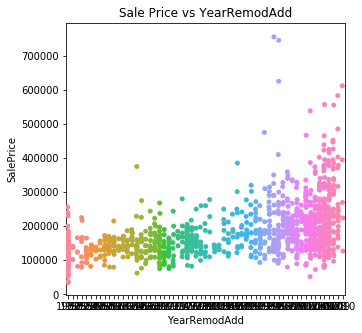

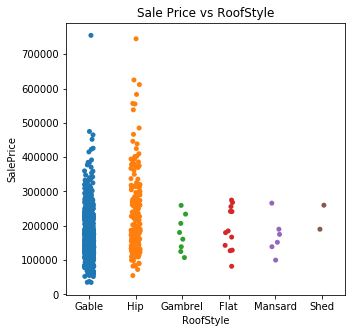

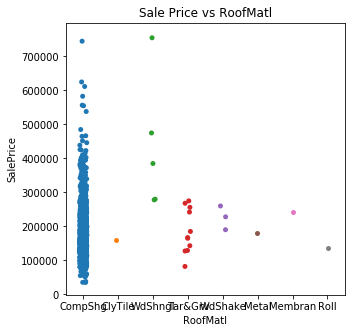

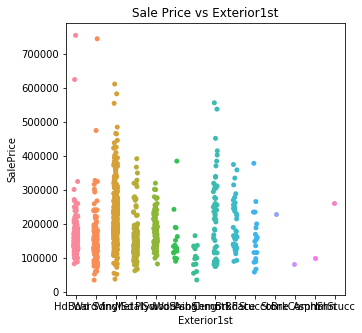

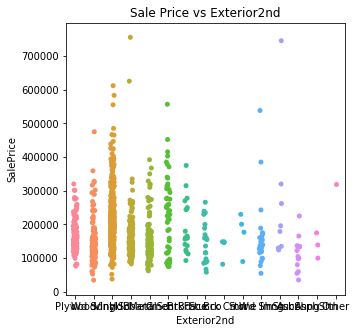

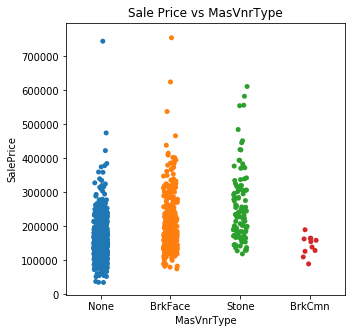

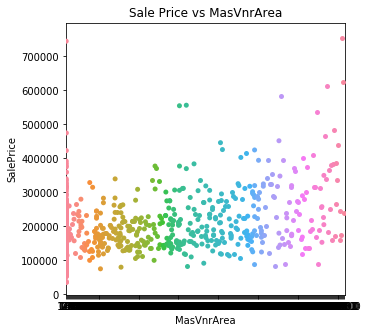

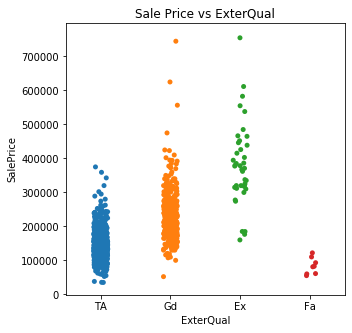

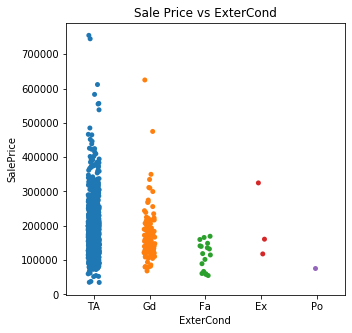

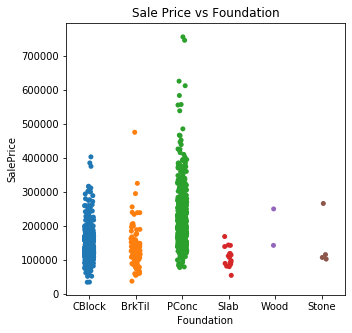

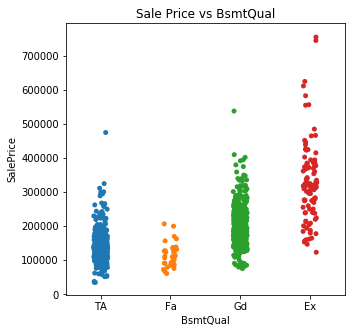

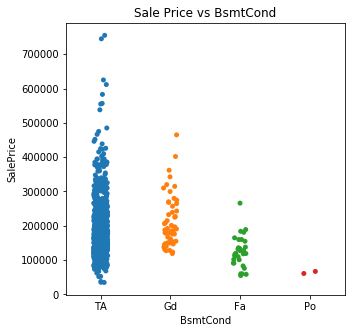

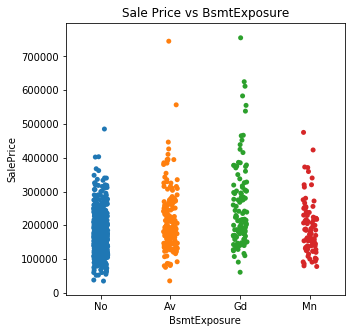

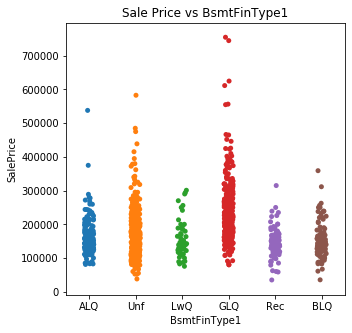

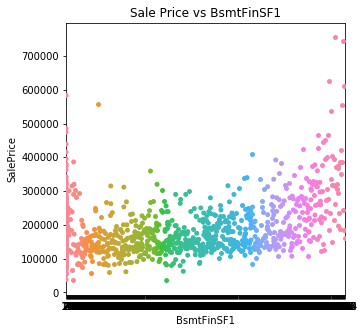

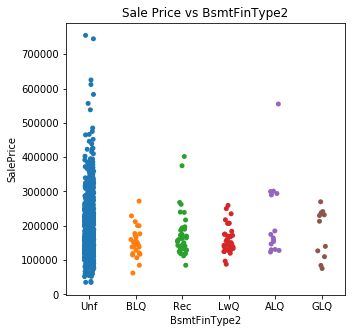

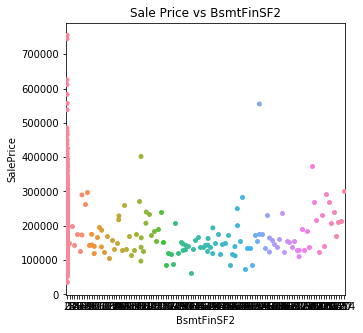

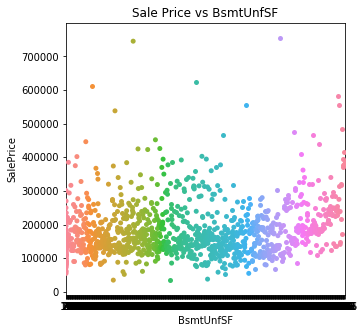

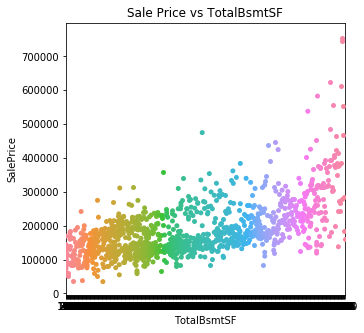

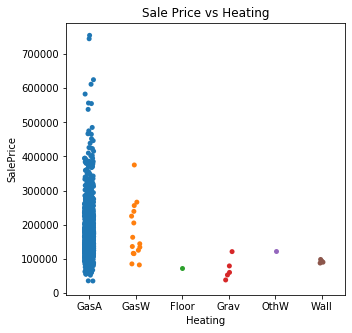

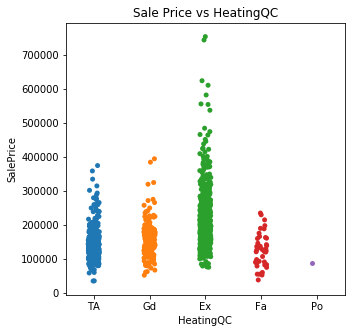

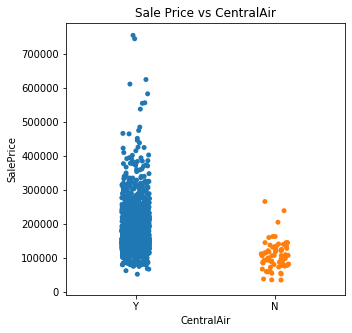

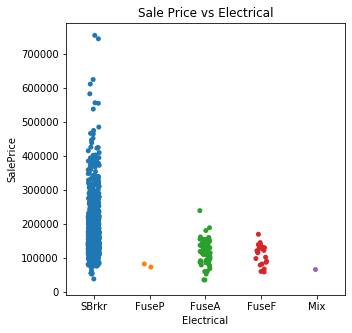

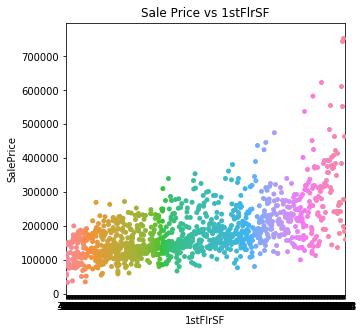

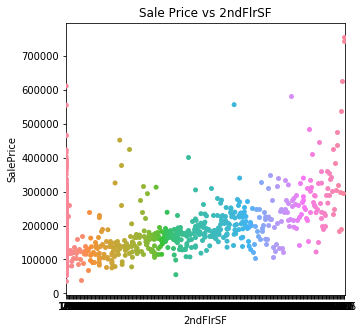

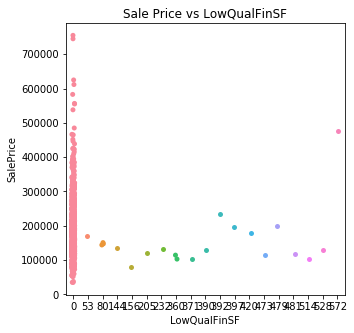

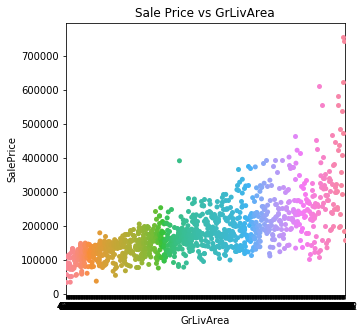

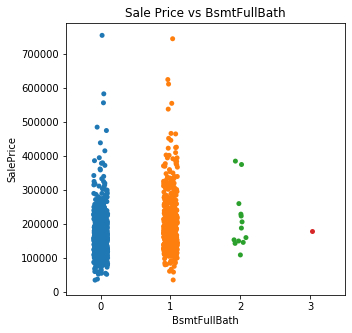

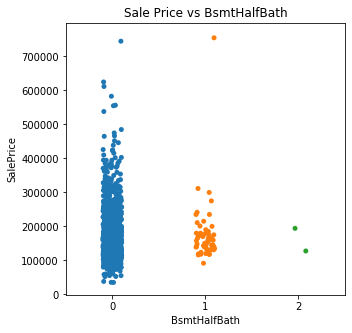

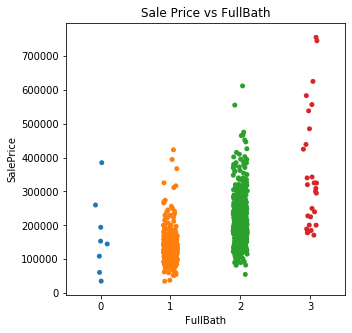

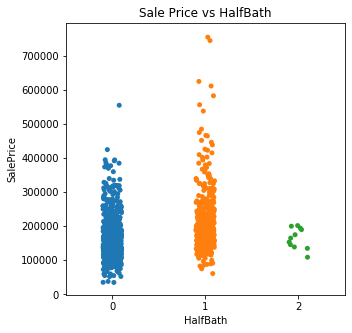

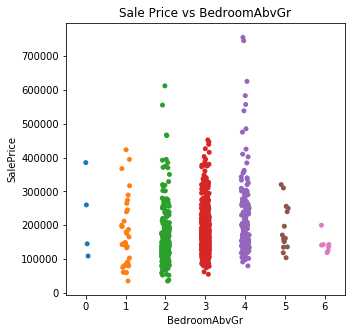

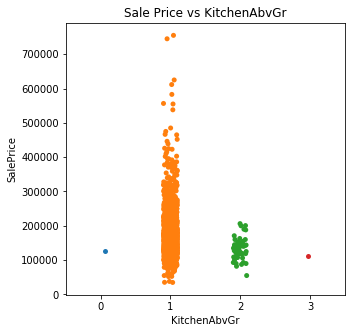

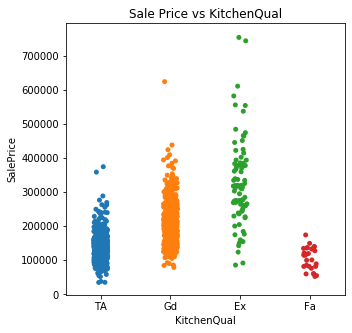

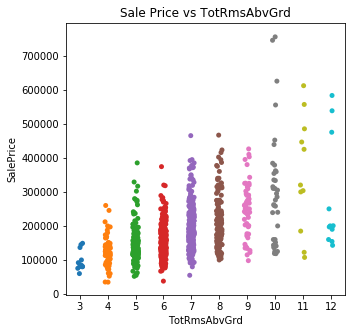

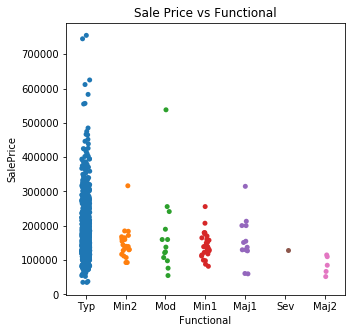

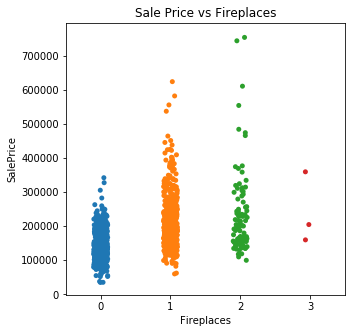

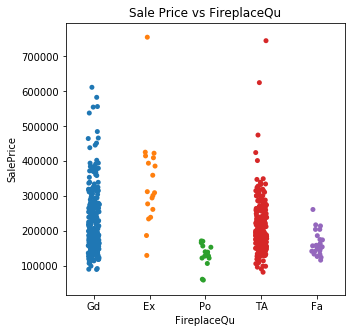

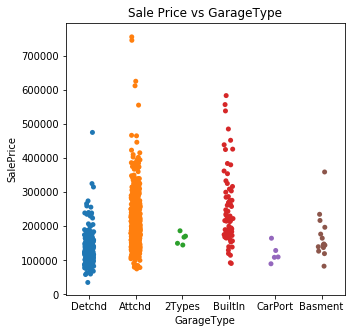

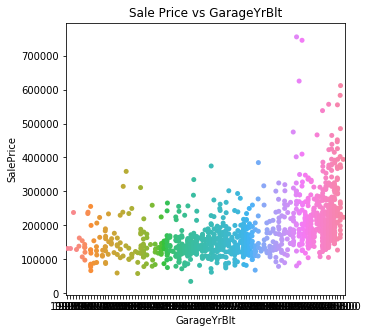

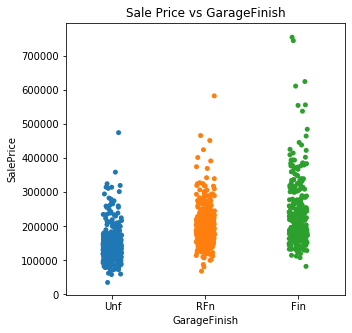

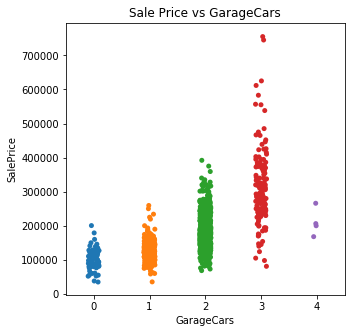

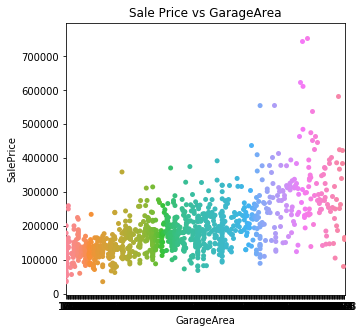

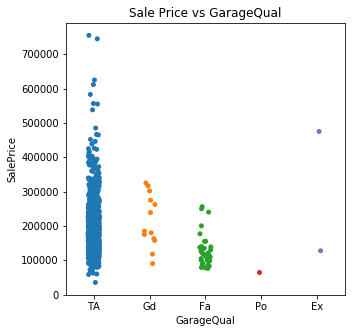

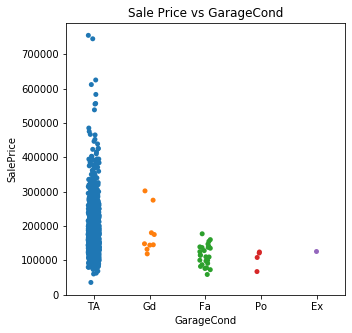

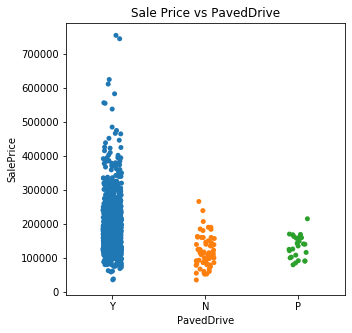

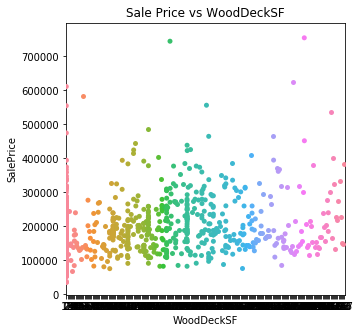

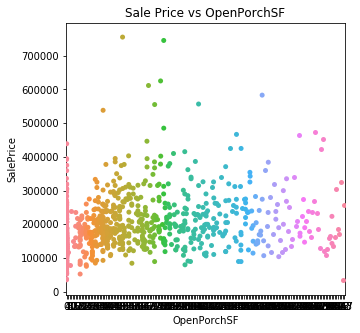

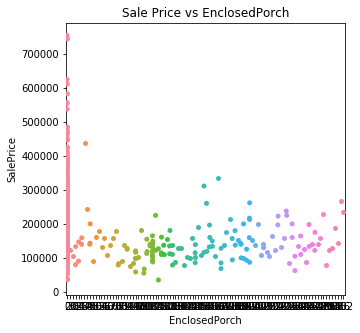

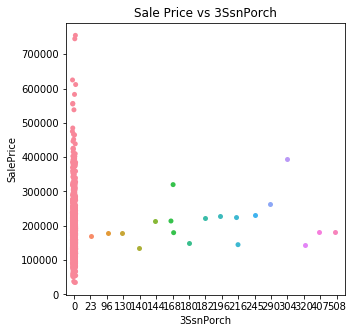

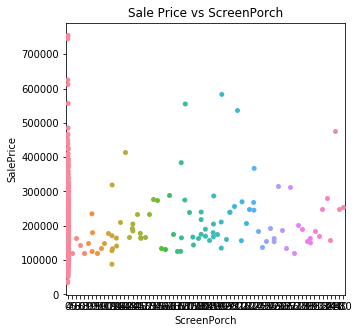

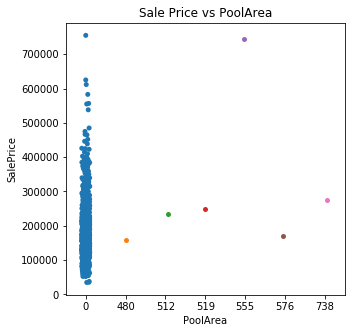

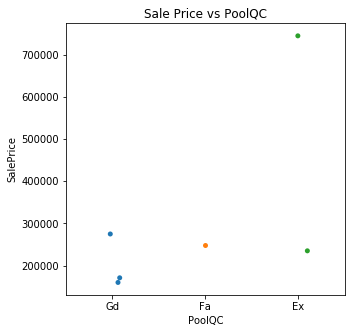

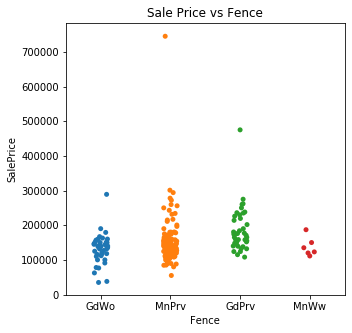

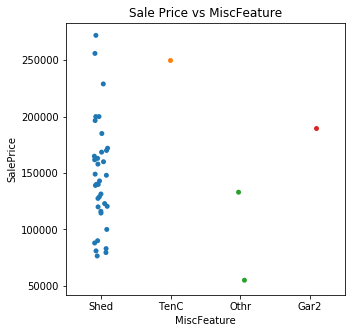

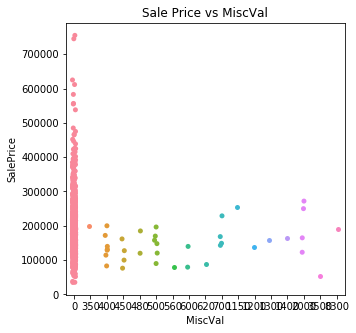

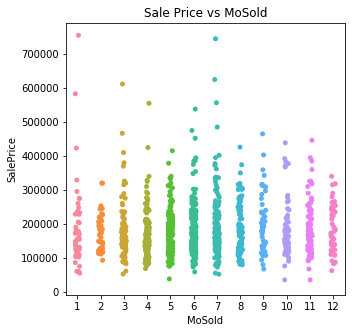

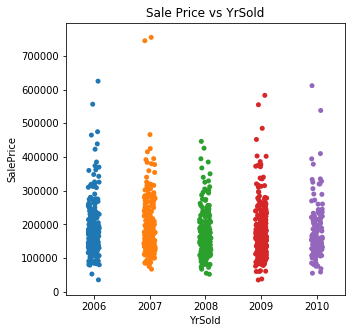

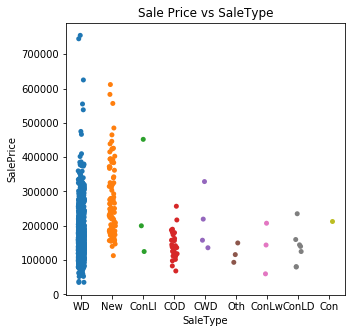

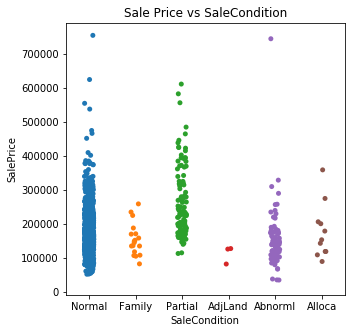

In [3]:
# Scatter Plots for all features vs target

for feature in train.columns:
    if feature != 'SalePrice':
        plt.figure(figsize = (5, 5))
        sns.stripplot(x = feature, y = 'SalePrice', hue = None, data = train)
        plt.title(f'Sale Price vs {feature}')
        plt.show()

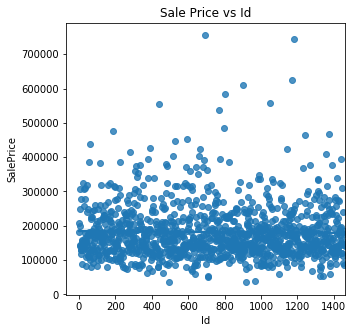

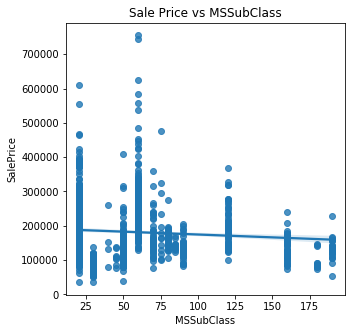

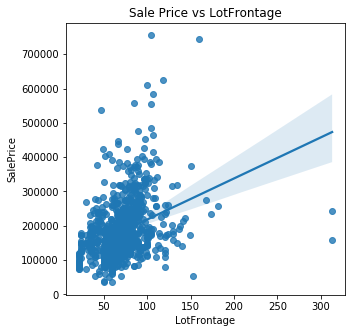

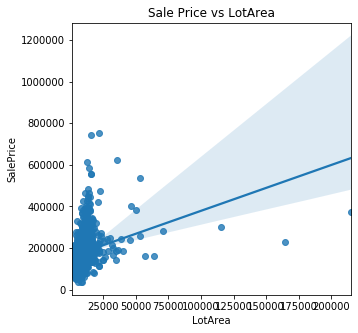

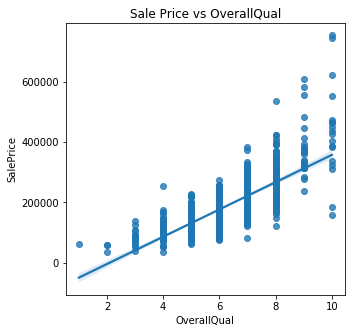

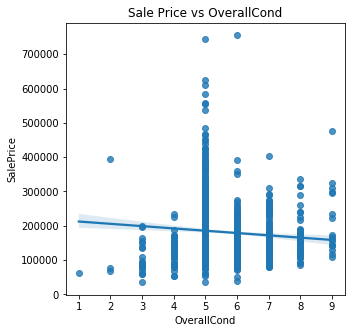

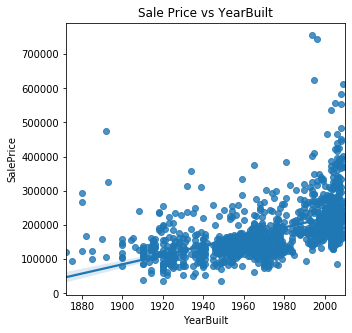

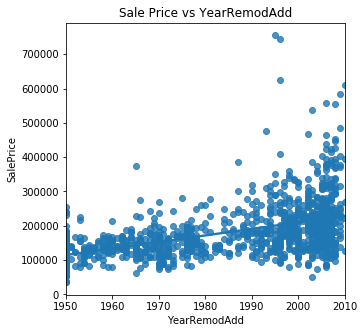

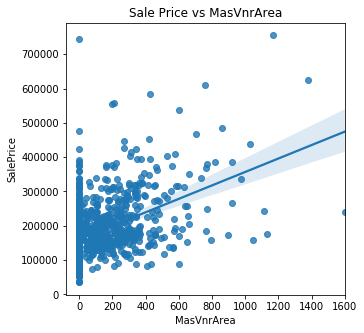

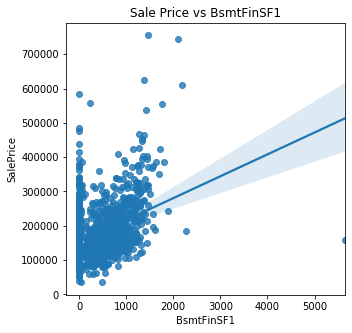

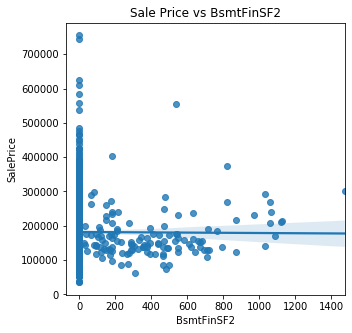

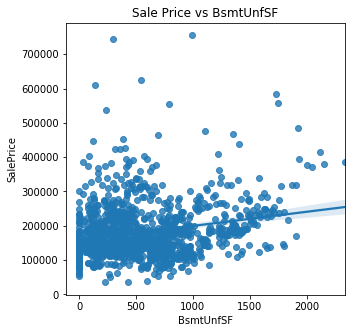

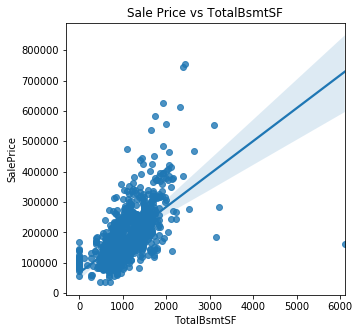

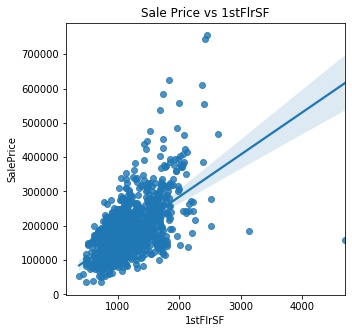

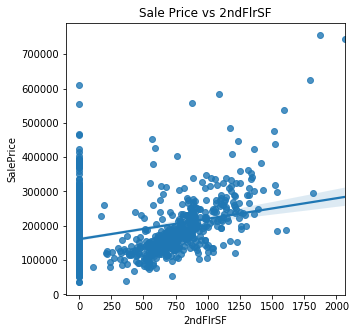

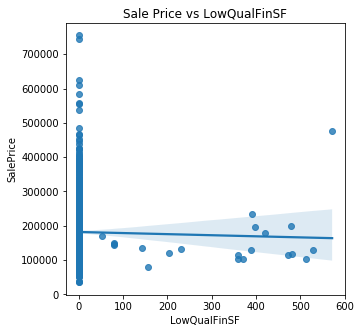

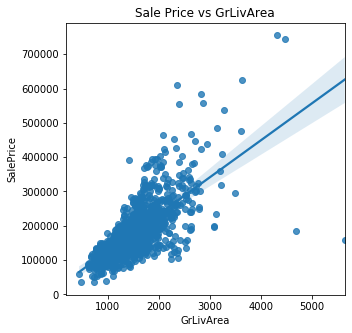

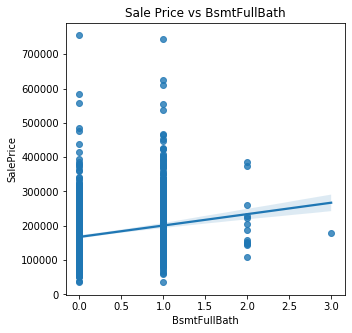

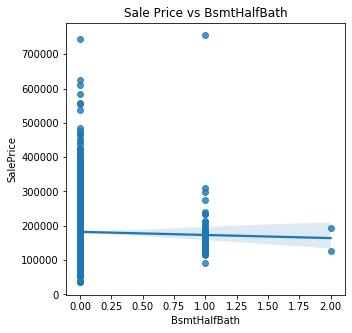

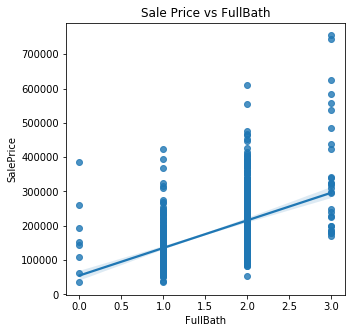

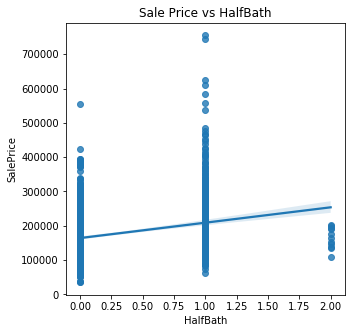

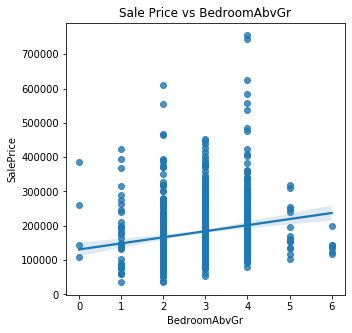

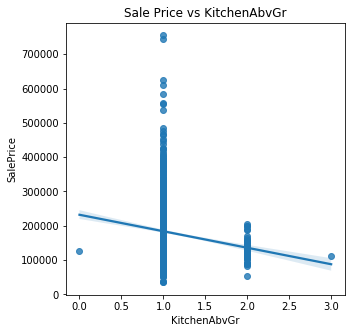

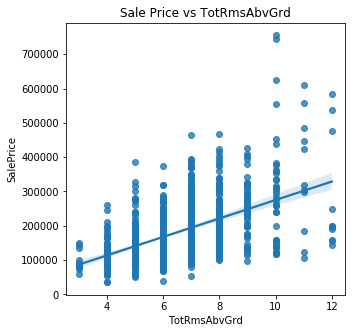

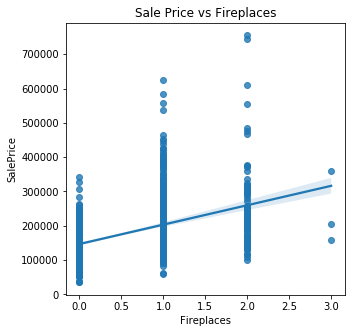

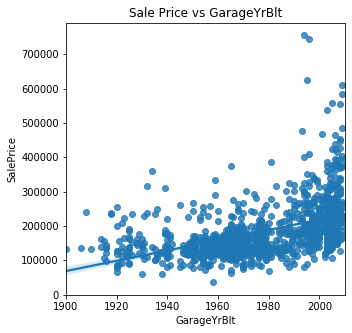

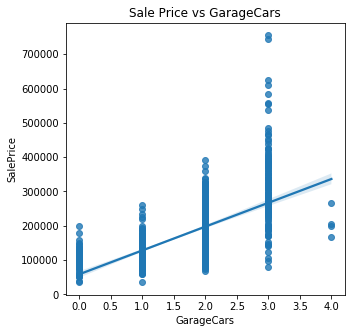

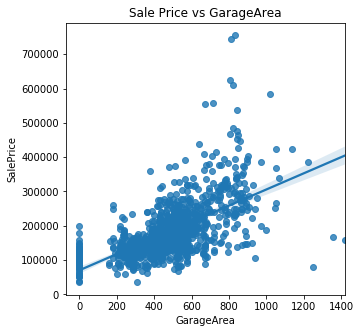

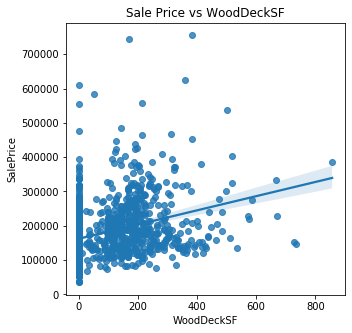

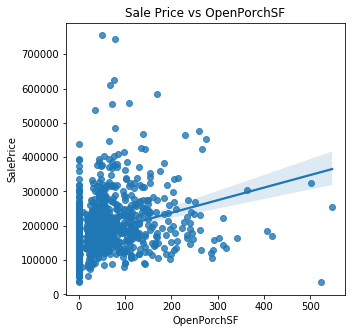

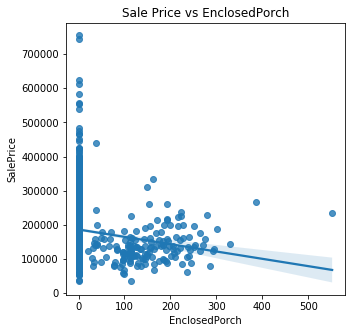

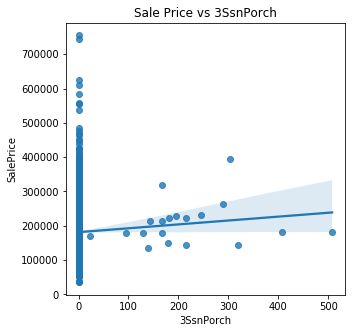

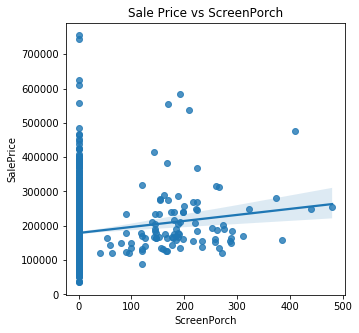

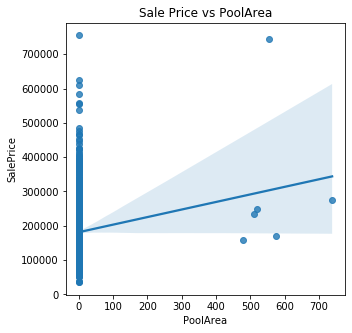

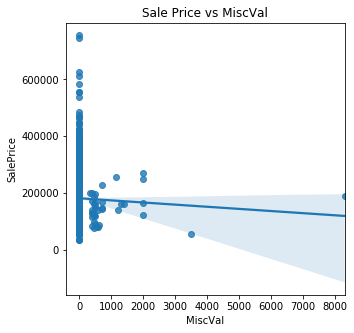

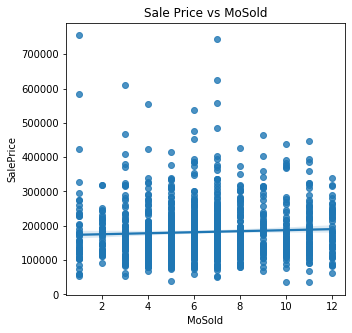

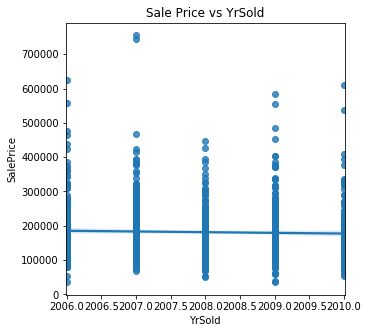

In [4]:
# Let's try to do regression only for numerical features vs target

count = 0

for feature in train.columns:
    if is_numeric_dtype(train[feature]) and feature != 'SalePrice':
        count += 1
        plt.figure(figsize = (5, 5))
        plt.title(f'Sale Price vs {feature}')
        sns.regplot(x = feature, y = 'SalePrice', data = train)
        plt.show()

Some initial thoughts based on these graphs:
1. Many of these features do not seem correlated with our target. However, we must not forget that there may be interactions between these seemingly irrelevant features which ARE correlated with our target.
2. There is clear correlation between square footage and price, number of rooms and price, and age and price.

# Preprocessing the Data

Before we start selecting and training models, we have to preprocess our data. This includes things like dealing with missing values, encoding categorical features, and scaling the data to a normal range.

In [5]:
display(train)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
71      72          20       RL         69.0     7599   Pave   NaN      Reg   
264    265          30       RM         30.0     5232   Pave  Grvl      IR3   
1377  1378          50       RL         60.0    10998   Pave  Grvl      Reg   
756    757          60       RL         68.0    10769   Pave   NaN      IR1   
1207  1208          20       RL         70.0     9135   Pave   NaN      Reg   
...    ...         ...      ...          ...      ...    ...   ...      ...   
561    562          20       RL         77.0    10010   Pave   NaN      Reg   
121    122          50       RM         50.0     6060   Pave   NaN      Reg   
1176  1177          20       RL         37.0     6951   Pave   NaN      IR1   
1174  1175          70       RL         80.0    16560   Pave   NaN      IR1   
461    462          70       RL         60.0     7200   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
71           Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
264          Bnk    AllPub  ...        0    NaN    NaN         NaN       0   
1377         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
756          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1207         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
561          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
121          Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1176         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1174         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
461          Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
71        6   2007        WD         Normal     129500  
264       6   2008        WD         Normal      73000  
1377      7   2009        WD         Normal     117000  
756       4   2009        WD         Normal     212000  
1207      5   2006        WD         Normal     200000  
...     ...    ...       ...            ...        ...  
561       4   2006        WD         Normal     170000  
121       6   2007        WD         Normal     100000  
1176     10   2008        WD         Normal     119500  
1174      7   2006        WD         Normal     239000  
461       4   2009        WD         Normal     155000  

[1168 rows x 81 columns]

In [6]:
display(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1168.000000  1168.000000   964.000000    1168.000000  1168.000000   
mean    737.382705    56.708048    70.132780   10576.801370     6.110445   
std     422.015133    42.561186    25.104868   10028.575052     1.391846   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     370.500000    20.000000    59.000000    7448.250000     5.000000   
50%     749.500000    50.000000    69.000000    9495.000000     6.000000   
75%    1097.750000    70.000000    80.000000   11665.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1168.000000  1168.000000   1168.000000  1161.000000  1168.000000  ...   
mean      5.570205  1971.845890   1985.181507   105.441860   450.917808  ...   
std       1.103955    30.081755     20.493139   185.342889   460.623452  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.500000   1994.000000     0.000000   390.000000  ...   
75%       6.000000  2001.000000   2004.000000   166.000000   724.000000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1168.000000  1168.000000    1168.000000  1168.000000  1168.000000   
mean     95.011130    47.662671      20.885274     3.511130    15.940925   
std     125.915679    68.002250      59.547412    30.661933    57.783072   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    26.000000       0.000000     0.000000     0.000000   
75%     168.250000    69.250000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea      MiscVal       MoSold       YrSold      SalePrice  
count  1168.000000  1168.000000  1168.000000  1168.000000    1168.000000  
mean      2.893836    33.339041     6.329623  2007.799658  181815.079623  
std      40.736249   306.520928     2.716873     1.327683   79907.300388  
min       0.000000     0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000     0.000000     5.000000  2007.000000  130375.000000  
50%       0.000000     0.000000     6.000000  2008.000000  164600.000000  
75%       0.000000     0.000000     8.000000  2009.000000  215000.000000  
max     738.000000  8300.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

## Dealing with missing values

We have a number of choices for dealing with missing values. Let's begin by dropping features which are missing a lot of data (15% or more).

We have to drop from valid, train, and test sets. ONLY USE THE INFO FROM THE TRAIN TO MAKE THE DROPS.

In [8]:
train_null = train.isnull()
train_null_sum = train_null[train_null.columns[train_null.sum() > len(train) * .15]].sum()
display(train_null_sum)
print('')
display(train.columns[train.isnull().sum() > len(train) * .15])
print('')
display(train[train.columns[train.isnull().sum() > len(train) * .15]])

LotFrontage     204
Alley          1094
FireplaceQu     546
PoolQC         1162
Fence           945
MiscFeature    1128
dtype: int64

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

LotFrontage Alley FireplaceQu PoolQC  Fence MiscFeature
71           69.0   NaN         NaN    NaN    NaN         NaN
264          30.0  Grvl         NaN    NaN    NaN         NaN
1377         60.0  Grvl         NaN    NaN    NaN         NaN
756          68.0   NaN         NaN    NaN    NaN         NaN
1207         70.0   NaN         NaN    NaN    NaN         NaN
...           ...   ...         ...    ...    ...         ...
561          77.0   NaN          TA    NaN    NaN         NaN
121          50.0   NaN         NaN    NaN  MnPrv         NaN
1176         37.0   NaN         NaN    NaN  MnPrv         NaN
1174         80.0   NaN          Gd    NaN    NaN         NaN
461          60.0   NaN         NaN    NaN  MnPrv         NaN

[1168 rows x 6 columns]

All of these features seem peripheral, and not useful to our model, so let's just drop them.

In [9]:
columns_to_drop = train.loc[:, train.isnull().sum() > len(train) * .15].columns
display(columns_to_drop)
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)
display(train)
display(valid)
display(test)

Index(['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
71      72          20       RL     7599   Pave      Reg         Lvl   
264    265          30       RM     5232   Pave      IR3         Bnk   
1377  1378          50       RL    10998   Pave      Reg         Lvl   
756    757          60       RL    10769   Pave      IR1         Lvl   
1207  1208          20       RL     9135   Pave      Reg         Lvl   
...    ...         ...      ...      ...    ...      ...         ...   
561    562          20       RL    10010   Pave      Reg         Lvl   
121    122          50       RM     6060   Pave      Reg         Lvl   
1176  1177          20       RL     6951   Pave      IR1         Lvl   
1174  1175          70       RL    16560   Pave      IR1         Lvl   
461    462          70       RL     7200   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
71      AllPub    Corner       Gtl  ...             0         0           0   
264     AllPub    Inside       Gtl  ...             0         0           0   
1377    AllPub    Inside       Gtl  ...             0         0           0   
756     AllPub    Inside       Gtl  ...             0         0           0   
1207    AllPub    Inside       Gtl  ...             0         0           0   
...        ...       ...       ...  ...           ...       ...         ...   
561     AllPub    Inside       Mod  ...             0         0           0   
121     AllPub    Inside       Gtl  ...           140         0           0   
1176    AllPub   CulDSac       Gtl  ...             0         0           0   
1174    AllPub    Inside       Gtl  ...             0         0           0   
461     AllPub    Inside       Gtl  ...             0         0           0   

     PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
71          0       0       6    2007        WD         Normal    129500  
264         0       0       6    2008        WD         Normal     73000  
1377        0       0       7    2009        WD         Normal    117000  
756         0       0       4    2009        WD         Normal    212000  
1207        0       0       5    2006        WD         Normal    200000  
...       ...     ...     ...     ...       ...            ...       ...  
561         0       0       4    2006        WD         Normal    170000  
121         0       0       6    2007        WD         Normal    100000  
1176        0       0      10    2008        WD         Normal    119500  
1174        0       0       7    2006        WD         Normal    239000  
461         0       0       4    2009        WD         Normal    155000  

[1168 rows x 75 columns]

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
830    831          20       RL    11900   Pave      IR1         Lvl   
789    790          60       RL    12205   Pave      IR1         Low   
127    128          45       RM     4388   Pave      IR1         Bnk   
413    414          30       RM     8960   Pave      Reg         Lvl   
545    546          50       RL    13837   Pave      IR1         Lvl   
...    ...         ...      ...      ...    ...      ...         ...   
721    722         120       RM     4426   Pave      Reg         Lvl   
1299  1300          20       RL     7500   Pave      Reg         Lvl   
1440  1441          70       RL    11526   Pave      IR1         Bnk   
1226  1227          60       RL    14598   Pave      IR1         Lvl   
1289  1290          60       RL    11065   Pave      IR1         Lvl   

     Utilities LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch  \
830     AllPub    Corner       Gtl  ...             0         0         192   
789     AllPub    Inside       Gtl  ...             0         0           0   
127     AllPub    Inside       Gtl  ...             0         0           0   
413     AllPub    Inside       Gtl  ...           130         0           0   
545     AllPub    Corner       Gtl  ...             0         0           0   
...        ...       ...       ...  ...           ...       ...         ...   
721     AllPub    Inside       Gtl  ...             0         0           0   
1299    AllPub    Inside       Gtl  ...             0         0           0   
1440    AllPub    Inside       Mod  ...             0         0           0   
1226    AllPub   CulDSac       Gtl  ...             0         0           0   
1289    AllPub    Inside       Gtl  ...             0         0           0   

     PoolArea MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
830         0       0       6    2008        WD         Normal    166000  
789         0       0       7    2007        WD         Normal    187500  
127         0       0       6    2007        WD         Normal     87000  
413         0       0       3    2010        WD         Normal    115000  
545         0       0       2    2006        WD         Normal    229000  
...       ...     ...     ...     ...       ...            ...       ...  
721         0       0       5    2010        WD         Normal    143000  
1299        0       0       5    2010        WD         Normal    154000  
1440        0       0       9    2008        WD         Normal    191000  
1226        0       0       1    2008        WD         Normal    214000  
1289        0       0      10    2006       New        Partial    281000  

[292 rows x 75 columns]

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour  \
0     1461          20       RH    11622   Pave      Reg         Lvl   
1     1462          20       RL    14267   Pave      IR1         Lvl   
2     1463          60       RL    13830   Pave      IR1         Lvl   
3     1464          60       RL     9978   Pave      IR1         Lvl   
4     1465         120       RL     5005   Pave      IR1         HLS   
...    ...         ...      ...      ...    ...      ...         ...   
1454  2915         160       RM     1936   Pave      Reg         Lvl   
1455  2916         160       RM     1894   Pave      Reg         Lvl   
1456  2917          20       RL    20000   Pave      Reg         Lvl   
1457  2918          85       RL    10441   Pave      Reg         Lvl   
1458  2919          60       RL     9627   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope  ... OpenPorchSF EnclosedPorch 3SsnPorch  \
0       AllPub    Inside       Gtl  ...           0             0         0   
1       AllPub    Corner       Gtl  ...          36             0         0   
2       AllPub    Inside       Gtl  ...          34             0         0   
3       AllPub    Inside       Gtl  ...          36             0         0   
4       AllPub    Inside       Gtl  ...          82             0         0   
...        ...       ...       ...  ...         ...           ...       ...   
1454    AllPub    Inside       Gtl  ...           0             0         0   
1455    AllPub    Inside       Gtl  ...          24             0         0   
1456    AllPub    Inside       Gtl  ...           0             0         0   
1457    AllPub    Inside       Gtl  ...          32             0         0   
1458    AllPub    Inside       Mod  ...          48             0         0   

     ScreenPorch PoolArea  MiscVal  MoSold  YrSold  SaleType SaleCondition  
0            120        0        0       6    2010        WD        Normal  
1              0        0    12500       6    2010        WD        Normal  
2              0        0        0       3    2010        WD        Normal  
3              0        0        0       6    2010        WD        Normal  
4            144        0        0       1    2010        WD        Normal  
...          ...      ...      ...     ...     ...       ...           ...  
1454           0        0        0       6    2006        WD        Normal  
1455           0        0        0       4    2006        WD       Abnorml  
1456           0        0        0       9    2006        WD       Abnorml  
1457           0        0      700       7    2006        WD        Normal  
1458           0        0        0      11    2006        WD        Normal  

[1459 rows x 74 columns]

That was a good start, but we still have a lot of missing values throughout our data. Let's do simple imputting for the rest, with median for numerical features and mode for categorical features. sklearn has a great function for this built in.

In [10]:
num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

display(num_columns)
display(cat_columns)

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
valid.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

## Categorical Features

Let's look at the Categorical Features and decide what to do with them.

In [12]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

MSZoning Street LotShape LandContour Utilities LotConfig LandSlope  \
71         RL   Pave      Reg         Lvl    AllPub    Corner       Gtl   
264        RM   Pave      IR3         Bnk    AllPub    Inside       Gtl   
1377       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
756        RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
1207       RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   
...       ...    ...      ...         ...       ...       ...       ...   
561        RL   Pave      Reg         Lvl    AllPub    Inside       Mod   
121        RM   Pave      Reg         Lvl    AllPub    Inside       Gtl   
1176       RL   Pave      IR1         Lvl    AllPub   CulDSac       Gtl   
1174       RL   Pave      IR1         Lvl    AllPub    Inside       Gtl   
461        RL   Pave      Reg         Lvl    AllPub    Inside       Gtl   

     Neighborhood Condition1 Condition2  ... Electrical KitchenQual  \
71        Mitchel       Norm       Norm  ...      SBrkr          TA   
264       OldTown     Artery       Norm  ...      FuseP          TA   
1377      Edwards       Norm       Norm  ...      SBrkr          TA   
756       CollgCr       Norm       Norm  ...      SBrkr          Gd   
1207      CollgCr       Norm       Norm  ...      SBrkr          Gd   
...           ...        ...        ...  ...        ...         ...   
561       Mitchel       Norm       Norm  ...      SBrkr          TA   
121        IDOTRR       Norm       Norm  ...      SBrkr          TA   
1176      Mitchel       Norm       Norm  ...      SBrkr          TA   
1174      Crawfor       Norm       Norm  ...      SBrkr          TA   
461         SWISU      Feedr       Norm  ...      SBrkr          Gd   

     Functional GarageType GarageFinish GarageQual GarageCond PavedDrive  \
71          Typ     Detchd          Unf         TA         TA          Y   
264         Typ     Detchd          Unf         TA         TA          N   
1377       Min2     Detchd          Unf         TA         TA          Y   
756         Typ     Attchd          RFn         TA         TA          Y   
1207        Typ     Attchd          RFn         TA         TA          Y   
...         ...        ...          ...        ...        ...        ...   
561         Typ     Attchd          RFn         TA         TA          Y   
121         Typ     Detchd          Unf         TA         TA          P   
1176        Typ     Attchd          Unf         TA         TA          Y   
1174        Typ     Detchd          Unf         TA         TA          Y   
461         Typ     Detchd          RFn         TA         TA          Y   

     SaleType SaleCondition  
71         WD        Normal  
264        WD        Normal  
1377       WD        Normal  
756        WD        Normal  
1207       WD        Normal  
...       ...           ...  
561        WD        Normal  
121        WD        Normal  
1176       WD        Normal  
1174       WD        Normal  
461        WD        Normal  

[1168 rows x 38 columns]

Many of these variable seem ripe for an ordinal encoding, where we turn each entry into a number, like 0, 1, 2, 3... Note that this is a good idea for categorical features which have some inherent order. But if the feature is not ordered in some sense, then ordinal encoding will confuse the algorithm into believing* there is some inherent order. Certianly there is room for debate on just how ordinal some of these features are.  

*No, machines can't think, I'm just anthropomorphising.

Here's a list of features that seem ordinal to me:  
1. LotShape: How regular or irregular the property is shaped
2. Utilities: Which utilities are available, as a chain of sets, which gives order.
3. LandSlope: How sloped the property is
4. ExterQual: Evaluates the quality of the material on the exterior 
5. ExterCond: Evaluates the present condition of the material on the exterior
6. BsmtQual: Evaluates the height of the basement
7. BsmtCond: Evaluates the general condition of the basement
8. BsmtExposure: Refers to walkout or garden level walls
9. BsmtFinType1: Rating of basement finished area
10. BsmtFinType2: Rating of basement finished area (if multiple types)
11. HeatingQC: Heating quality and condition
12. CentralAir: Central air conditioning
13. Electrical: Electrical system
14. KitchenQual: Kitchen quality
15. Functional: Home functionality (Assume typical unless deductions are warranted)
16. FireplaceQu: Fireplace quality. BUT we already dropped this, as it was missing too many values.
17. GarageFinish: Interior finish of the garage
18. GarageQual: Garage quality
19. GarageCond: Garage condition
20. PavedDrive: Paved driveway
21. PoolQC: Pool quality. But, we already dropped this, as it was missing too many values.
22. Fence Quality. BUT, we already dropped this, as it was missing too many values.

While sklearn has a nice OrdinalEncoder built in, it can't know the real world values of these descriptions (e.g. for Garage Finish we should have Finished > Rough Finished > Unfinished > No Garage, though even here there could be debate about whether No Garage is truly lower than the other options, or just incomparable). Therefore, I will have to manually encode all of these...  

Sigh...

In [13]:
# Here are all our maps
# I'm following the convention of giving the worst value 0, and the best the maximum

lotshape_map = {'Reg':3, 'IR1':2, 'IR2':1, 'IR2':0}
utilities_map = {'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
landslope_map = {'Gtl':2, 'Mod':1, 'Sev':0}
exterqual_map = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0}
extercond_map = exterqual_map
bsmtqual_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0}
bsmtcond_map = bsmtqual_map
bsmtexposure_map = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NA':0}

# BSMTFinType1 is a bit strange, because they throw Rec Room in with all the other assesments. I'll set the two averages equal in value, then scale the rest
bsmtfintype1_map = {'GLQ':5, 'ALQ':4, 'BLQ':3, 'Rec':4, 'LwQ':2, 'Unf':1, 'NA':0}
bsmtfintype2_map = bsmtfintype1_map

heatingqc_map = exterqual_map
centralair_map = {'Y':1, 'N':0}

# Electrical is also weird, as there is a mixed option. I'll just set that to a middle value.
electrical_map = {'SBrkr':3, 'FuseA':2, 'FuseF':1, 'FuseP':0}

kitchenqual_map = exterqual_map
functional_map = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0}
garagefinish_map = {'Fin':3, 'RFn':2, 'Unf':1, 'NA':0}
garagequal_map = bsmtqual_map
garagecond_map = bsmtqual_map
paveddrive_map = {'Y':2, 'P':1, 'N':0}

# Here is a list of the maps I just made, so we can just iterate through them
ordinal_maps = [lotshape_map, utilities_map, landslope_map, exterqual_map, extercond_map, bsmtqual_map, bsmtcond_map, bsmtexposure_map, bsmtfintype1_map, bsmtfintype2_map, heatingqc_map, centralair_map, electrical_map, kitchenqual_map, functional_map, garagefinish_map, garagequal_map, garagecond_map, paveddrive_map]

# Here's our list of columns to map, so we can just iterate through them

ordinal_features = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']

In [14]:
for i in range(len(ordinal_maps)):
    train[ordinal_features[i]] = train[ordinal_features[i]].map(ordinal_maps[i])
    valid[ordinal_features[i]] = valid[ordinal_features[i]].map(ordinal_maps[i])
    test[ordinal_features[i]] = test[ordinal_features[i]].map(ordinal_maps[i])

display(train[ordinal_features])
display(valid[ordinal_features])
display(test[ordinal_features])

LotShape  Utilities  LandSlope  ExterQual  ExterCond  BsmtQual  \
71         3.0          3          2          2          2         3   
264        NaN          3          2          2          2         2   
1377       3.0          3          2          2          2         3   
756        2.0          3          2          3          2         4   
1207       3.0          3          2          3          2         4   
...        ...        ...        ...        ...        ...       ...   
561        3.0          3          1          2          2         4   
121        3.0          3          2          2          2         3   
1176       2.0          3          2          2          2         3   
1174       2.0          3          2          2          2         4   
461        3.0          3          2          3          3         4   

      BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  HeatingQC  \
71           3             1             4             1          2   
264          3             1             1             1          3   
1377         3             1             2             3          4   
756          3             3             5             1          4   
1207         3             3             5             1          4   
...        ...           ...           ...           ...        ...   
561          3             3             4             2          3   
121          3             1             1             1          3   
1176         3             1             4             1          2   
1174         3             1             4             1          2   
461          4             1             4             3          4   

      CentralAir  Electrical  KitchenQual  Functional  GarageFinish  \
71             1         3.0            2           7             1   
264            0         0.0            2           7             1   
1377           1         3.0            2           5             1   
756            1         3.0            3           7             2   
1207           1         3.0            3           7             2   
...          ...         ...          ...         ...           ...   
561            1         3.0            2           7             2   
121            1         3.0            2           7             1   
1176           1         3.0            2           7             1   
1174           1         3.0            2           7             1   
461            1         3.0            3           7             2   

      GarageQual  GarageCond  PavedDrive  
71             3           3           2  
264            3           3           0  
1377           3           3           2  
756            3           3           2  
1207           3           3           2  
...          ...         ...         ...  
561            3           3           2  
121            3           3           1  
1176           3           3           2  
1174           3           3           2  
461            3           3           2  

[1168 rows x 19 columns]

LotShape  Utilities  LandSlope  ExterQual  ExterCond  BsmtQual  \
830          2          3          2          2          2         3   
789          2          3          2          2          2         3   
127          2          3          2          2          3         3   
413          3          3          2          2          2         3   
545          2          3          2          3          3         4   
...        ...        ...        ...        ...        ...       ...   
721          3          3          2          3          2         4   
1299         3          3          2          2          2         3   
1440         2          3          1          2          2         5   
1226         2          3          2          3          2         4   
1289         2          3          2          3          2         4   

      BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  HeatingQC  \
830          3             1             4             1          2   
789          2             4             2             1          3   
127          3             1             2             1          4   
413          3             1             1             1          3   
545          4             1             5             2          3   
...        ...           ...           ...           ...        ...   
721          3             3             5             1          4   
1299         3             1             2             4          4   
1440         3             1             1             1          1   
1226         3             2             1             1          4   
1289         3             2             1             1          4   

      CentralAir  Electrical  KitchenQual  Functional  GarageFinish  \
830            1           2            2           7             2   
789            1           3            3           7             3   
127            1           3            2           7             1   
413            1           2            2           7             1   
545            1           3            3           7             1   
...          ...         ...          ...         ...           ...   
721            1           3            3           7             2   
1299           1           3            3           7             2   
1440           1           3            2           6             3   
1226           1           3            3           7             3   
1289           1           3            4           7             3   

      GarageQual  GarageCond  PavedDrive  
830            3           3           2  
789            3           3           2  
127            3           3           0  
413            3           3           2  
545            3           3           2  
...          ...         ...         ...  
721            3           3           2  
1299           3           3           2  
1440           3           3           2  
1226           3           3           2  
1289           3           3           2  

[292 rows x 19 columns]

LotShape  Utilities  LandSlope  ExterQual  ExterCond  BsmtQual  \
0          3.0          3          2          2          2         3   
1          2.0          3          2          2          2         3   
2          2.0          3          2          2          2         4   
3          2.0          3          2          2          2         3   
4          2.0          3          2          3          2         4   
...        ...        ...        ...        ...        ...       ...   
1454       3.0          3          2          2          2         3   
1455       3.0          3          2          2          2         3   
1456       3.0          3          2          2          2         3   
1457       3.0          3          2          2          2         4   
1458       3.0          3          1          2          2         4   

      BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  HeatingQC  \
0            3             1             4             2          2   
1            3             1             4             1          2   
2            3             1             5             1          3   
3            3             1             5             1          4   
4            3             1             4             1          4   
...        ...           ...           ...           ...        ...   
1454         3             1             1             1          3   
1455         3             1             4             1          2   
1456         3             1             4             1          4   
1457         3             3             5             1          2   
1458         3             3             2             1          4   

      CentralAir  Electrical  KitchenQual  Functional  GarageFinish  \
0              1           3            2           7             1   
1              1           3            3           7             1   
2              1           3            2           7             3   
3              1           3            3           7             3   
4              1           3            3           7             2   
...          ...         ...          ...         ...           ...   
1454           1           3            2           7             1   
1455           1           3            2           7             1   
1456           1           3            2           7             1   
1457           1           3            2           7             1   
1458           1           3            2           7             3   

      GarageQual  GarageCond  PavedDrive  
0              3           3           2  
1              3           3           2  
2              3           3           2  
3              3           3           2  
4              3           3           2  
...          ...         ...         ...  
1454           3           3           2  
1455           3           3           2  
1456           3           3           2  
1457           3           3           2  
1458           3           3           2  

[1459 rows x 19 columns]

Ok, let's see what categorical features are left to deal with.

In [15]:
train_cat = train.select_dtypes(exclude = [np.number])
display(train_cat)

MSZoning Street LandContour LotConfig Neighborhood Condition1 Condition2  \
71         RL   Pave         Lvl    Corner      Mitchel       Norm       Norm   
264        RM   Pave         Bnk    Inside      OldTown     Artery       Norm   
1377       RL   Pave         Lvl    Inside      Edwards       Norm       Norm   
756        RL   Pave         Lvl    Inside      CollgCr       Norm       Norm   
1207       RL   Pave         Lvl    Inside      CollgCr       Norm       Norm   
...       ...    ...         ...       ...          ...        ...        ...   
561        RL   Pave         Lvl    Inside      Mitchel       Norm       Norm   
121        RM   Pave         Lvl    Inside       IDOTRR       Norm       Norm   
1176       RL   Pave         Lvl   CulDSac      Mitchel       Norm       Norm   
1174       RL   Pave         Lvl    Inside      Crawfor       Norm       Norm   
461        RL   Pave         Lvl    Inside        SWISU      Feedr       Norm   

     BldgType HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd  \
71       1Fam     1Story     Gable  CompShg     HdBoard     Plywood   
264      1Fam     1Story     Gable  CompShg     Wd Sdng     Wd Sdng   
1377     1Fam     1.5Fin     Gable  CompShg     Wd Sdng     Wd Sdng   
756      1Fam     2Story     Gable  CompShg     VinylSd     VinylSd   
1207     1Fam     1Story     Gable  CompShg     VinylSd     VinylSd   
...       ...        ...       ...      ...         ...         ...   
561      1Fam     1Story     Gable  CompShg     HdBoard     HdBoard   
121      1Fam     1.5Fin     Gable  CompShg     AsbShng     AsbShng   
1176     1Fam     1Story     Gable  CompShg     HdBoard     Plywood   
1174     1Fam     2Story     Gable  CompShg     Wd Sdng     Wd Sdng   
461      1Fam     2Story     Gable  CompShg     Wd Sdng     Wd Sdng   

     MasVnrType Foundation Heating GarageType SaleType SaleCondition  
71         None     CBlock    GasA     Detchd       WD        Normal  
264        None     BrkTil    GasA     Detchd       WD        Normal  
1377       None     CBlock    GasA     Detchd       WD        Normal  
756        None      PConc    GasA     Attchd       WD        Normal  
1207    BrkFace      PConc    GasA     Attchd       WD        Normal  
...         ...        ...     ...        ...      ...           ...  
561        None     CBlock    GasA     Attchd       WD        Normal  
121        None      PConc    GasA     Detchd       WD        Normal  
1176       None     CBlock    GasA     Attchd       WD        Normal  
1174       None     BrkTil    GasA     Detchd       WD        Normal  
461        None      PConc    GasA     Detchd       WD        Normal  

[1168 rows x 19 columns]

Honestly, I'm not sure what to do with these features for right now, so let's DROP EM ALL!!!!

One-Hot would be my next choice, but who has time for that???

In [16]:
cat_columns = train.select_dtypes(include=['object']).columns

display(cat_columns)

train.drop(cat_columns, inplace = True, axis = 1)
valid.drop(cat_columns, inplace = True, axis = 1)
test.drop(cat_columns, inplace = True, axis = 1)

Index(['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')

## Numerical Features

Let's consider the correlation coefficients for each pair of Numerical Features.

Id  MSSubClass   LotArea  LotShape  Utilities  LandSlope  \
Id             1.000000   -0.003102 -0.019862  0.032086  -0.014407   0.005013   
MSSubClass    -0.003102    1.000000 -0.141486  0.098043   0.025258   0.036153   
LotArea       -0.019862   -0.141486  1.000000 -0.294504  -0.011091  -0.424726   
LotShape       0.032086    0.098043 -0.294504  1.000000   0.025659   0.133995   
Utilities     -0.014407    0.025258 -0.011091  0.025659   1.000000  -0.006445   
LandSlope      0.005013    0.036153 -0.424726  0.133995  -0.006445   1.000000   
OverallQual   -0.030645    0.027985  0.117210 -0.176957   0.002324   0.068031   
OverallCond    0.007834   -0.066340 -0.022527  0.025471  -0.011401  -0.002619   
YearBuilt     -0.009914    0.033941  0.021319 -0.222539   0.013479   0.075754   
YearRemodAdd  -0.032904    0.046797 -0.004928 -0.154155   0.038843   0.066439   
MasVnrArea    -0.055209    0.024658  0.089497 -0.062959  -0.069028   0.044365   
ExterQual      0.001841    0.009808  0.041679 -0.154134   0.020566   0.111697   
ExterCond      0.026650   -0.055292  0.008940 -0.010292   0.007458   0.038426   
BsmtQual      -0.045879    0.084173  0.077743 -0.200568   0.024517   0.037283   
BsmtCond      -0.012845   -0.004834  0.038131 -0.090111   0.001430  -0.011058   
BsmtExposure   0.026926    0.031000  0.239030 -0.154014   0.018539  -0.258536   
BsmtFinType1  -0.002732    0.020981  0.059207 -0.053647  -0.031634  -0.038547   
BsmtFinSF1    -0.000293   -0.076023  0.236721 -0.093225   0.021611  -0.112764   
BsmtFinType2  -0.010046   -0.046735  0.141625 -0.073581  -0.100420  -0.112435   
BsmtFinSF2     0.000517   -0.075108  0.141836 -0.069026  -0.055741  -0.112266   
BsmtUnfSF     -0.005912   -0.152146 -0.013746 -0.024213   0.014184   0.121958   
TotalBsmtSF   -0.005966   -0.256795  0.283596 -0.148529   0.016128  -0.037173   
HeatingQC     -0.017396   -0.017123 -0.004146 -0.116539   0.004679   0.054331   
CentralAir    -0.001860   -0.075477  0.054057 -0.107672  -0.007503   0.007141   
Electrical     0.026451    0.035188  0.052238 -0.110474   0.068815  -0.005231   
1stFlrSF       0.012957   -0.259446  0.328734 -0.147931  -0.013611  -0.070877   
2ndFlrSF      -0.009511    0.313725  0.035011 -0.087076   0.023333   0.034285   
LowQualFinSF  -0.048367    0.016856  0.008013  0.000769   0.003518  -0.000181   
GrLivArea     -0.002781    0.070968  0.272240 -0.181837   0.009678  -0.023787   
BsmtFullBath   0.020883    0.000104  0.193805 -0.033126   0.023975  -0.142097   
BsmtHalfBath  -0.019240   -0.002597  0.007509 -0.061442  -0.114222  -0.048248   
FullBath      -0.020374    0.125018  0.122353 -0.165798   0.030499   0.074571   
HalfBath      -0.006412    0.190979  0.022751 -0.115224   0.022634   0.001404   
BedroomAbvGr   0.031499   -0.033946  0.101510 -0.051254  -0.004853   0.070461   
KitchenAbvGr  -0.007167    0.280313 -0.019554  0.087809   0.006272   0.047176   
KitchenQual    0.014471   -0.010561  0.056705 -0.121785  -0.021398   0.042741   
TotRmsAbvGrd   0.023763    0.029127  0.189652 -0.098900  -0.008629   0.051659   
Functional     0.003825   -0.007620 -0.025693 -0.021227  -0.007013   0.117507   
Fireplaces    -0.021040   -0.048867  0.279068 -0.141204  -0.017477  -0.131447   
GarageYrBlt   -0.015254    0.092465 -0.025460 -0.186145   0.025526   0.093099   
GarageFinish   0.013345   -0.012827  0.110830 -0.205951  -0.007973   0.037314   
GarageCars     0.000879   -0.047535  0.169892 -0.180230  -0.008952   0.015104   
GarageArea     0.017990   -0.099439  0.204160 -0.160181  -0.007146   0.003102   
GarageQual     0.014768    0.069075  0.030357 -0.107493  -0.002491  -0.018735   
GarageCond    -0.013812    0.008698  0.020201 -0.070458  -0.002574   0.009192   
PavedDrive     0.003422   -0.070576  0.012861 -0.105910  -0.008359   0.025270   
WoodDeckSF    -0.045995   -0.007316  0.206965 -0.158443   0.022098  -0.098815   
OpenPorchSF    0.012311   -0.015375  0.075990 -0.087606  -0.030291   0.035841   
EnclosedPorch  0.013322   -0.018212 -0.024927  0.094

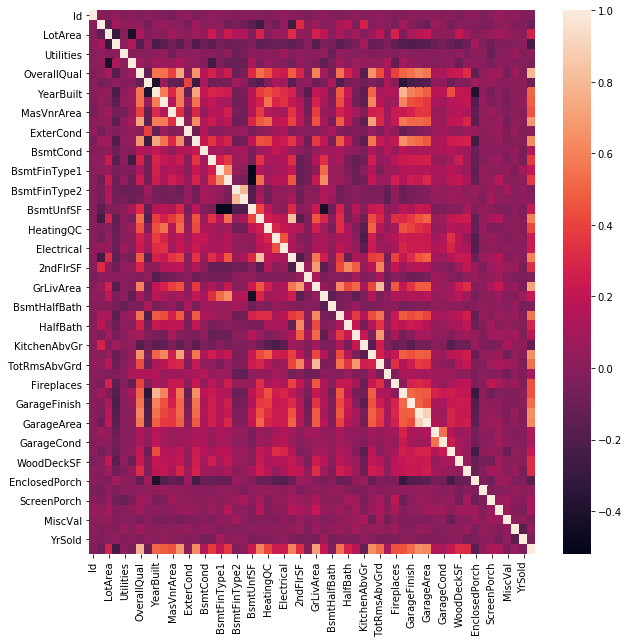

<Figure size 720x720 with 0 Axes>

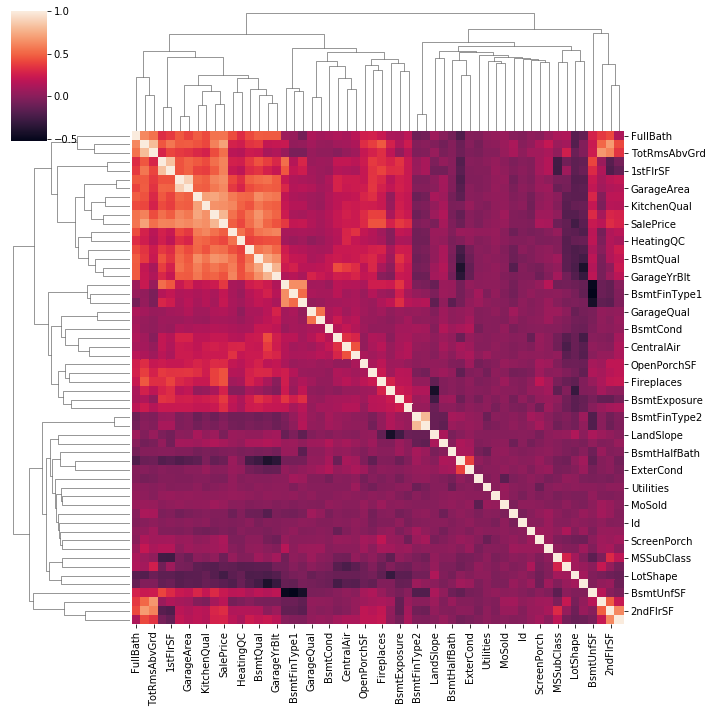

In [17]:
corr = train.corr()
display(corr)

plt.figure(figsize = (10, 10))
sns.heatmap(corr)
plt.show()

plt.figure(figsize = (10, 10))
sns.clustermap(corr)
plt.show()

Interesting. There's a lot more to consider here, but for now let's just focus on numerical features that are highly correlated with our target value.

In [18]:
display(corr['SalePrice'].sort_values())

LotShape        -0.247246
EnclosedPorch   -0.159839
KitchenAbvGr    -0.132224
OverallCond     -0.092579
MSSubClass      -0.088632
LandSlope       -0.039791
YrSold          -0.033426
BsmtFinType2    -0.029102
MiscVal         -0.028822
BsmtHalfBath    -0.027401
Id              -0.019337
LowQualFinSF    -0.019023
BsmtFinSF2      -0.006044
ExterCond        0.003575
Utilities        0.016241
3SsnPorch        0.043402
MoSold           0.050536
Functional       0.107672
GarageCond       0.108191
PoolArea         0.112468
ScreenPorch      0.126989
GarageQual       0.149085
BsmtCond         0.150409
BedroomAbvGr     0.177460
BsmtFinType1     0.209350
BsmtFullBath     0.216860
PavedDrive       0.220080
BsmtUnfSF        0.226502
Electrical       0.235018
CentralAir       0.242697
LotArea          0.276795
HalfBath         0.284553
OpenPorchSF      0.312772
WoodDeckSF       0.325986
2ndFlrSF         0.326620
BsmtFinSF1       0.367538
BsmtExposure     0.373353
HeatingQC        0.414816
GarageYrBlt 

Let's limit our model to just correlation coefficients .5 or above. That will bring us down to 14 numerical features.

In [19]:
corr_sp = corr['SalePrice']

print('')
columns_to_drop = corr_sp.loc[corr_sp < .5].index
display(columns_to_drop)

train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)

Index(['Id', 'MSSubClass', 'LotArea', 'LotShape', 'Utilities', 'LandSlope',
       'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'ExterCond', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'HeatingQC', 'CentralAir', 'Electrical',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'Functional', 'Fireplaces',
       'GarageYrBlt', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

Now, we need to do some feature scaling!! Normalize this stuff.

For this, and later steps, we'll need to split out our X and y values.

We'll need to reverse transform our predictions before the end, so let's not forget that.

In [20]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]

X_test = test

Ok, now we can scale the data. As always, only fit the the scaler on the TRAIN data, to prevent leakage.

Also, we have to do some reshaping to scale the y values.

Ok, having some trouble with scaling the data. Can't scale the y values for some reason.

I'll work on that later.

## Scaling the Data

Most ML models learn much better from data that is similarly scaled. So I will use a normal scaler to, well, normalize the data ranges.

In [21]:
# Also, scale the data!!
# Here, we're only scaling the domain, not the range. Should investigate whether it's worth it to scale the range as well


scaler = StandardScaler()
scaler.fit(X_train) 
X_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid),columns = X_valid.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

# Training The Model

Now that we're down to a manageable number of features, let's start training and comparing models. We'll start with decision tree, random forest, XGBoost, and LightGBM.

## Linear Regression

Need to do this.

## Decision Tree

'RMSE for Decision Tree Model is $37394.12612470222'

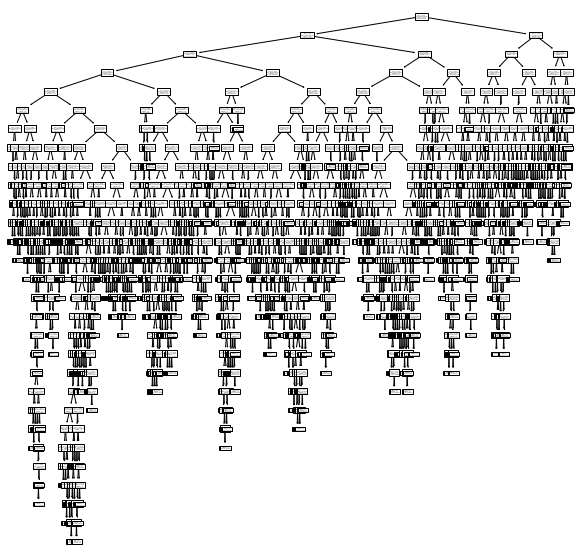

In [22]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))
display(f'RMSE for Decision Tree Model is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_decisiontree.csv',index=False, header =1)

plt.figure(figsize = (10,10))
plot_tree(model)
plt.show()

Well, I guess this isn't the worst, but given that the average sale price is 181286.518836, we're looking at about 20% error on average.

Ok, let's upload to Kaggle and compare:

Decision Tree Model got a score of 0.23263, which is not very good.

Look at that decision tree. Clearly we're substantially overfitting the training data. The methods below will help with that.

## Random Forest

Everyone knows random forest is way better than simple decision tree!!! Let's put that to the test.

In [23]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))
display(f'RMSE for Random Forest Model is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_randomforest.csv',index=False, header =1)



'RMSE for Random Forest Model is $28991.505515806683'

Alright, so far we're definitely beating Decision Tree. Let's also sumbit to Kaggle to see how we're doing.

model2 got a score of 0.16133, which is a SUBSTANTIAL improvement over the decision tree.

## XGBoost

XGBoost was the hottest model a few years ago. However, it's said to have been surpased by LightGBM these days. Let's find out!!!

[23:34:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



'RMSE for XGBoost Model is $28741.41461706218'

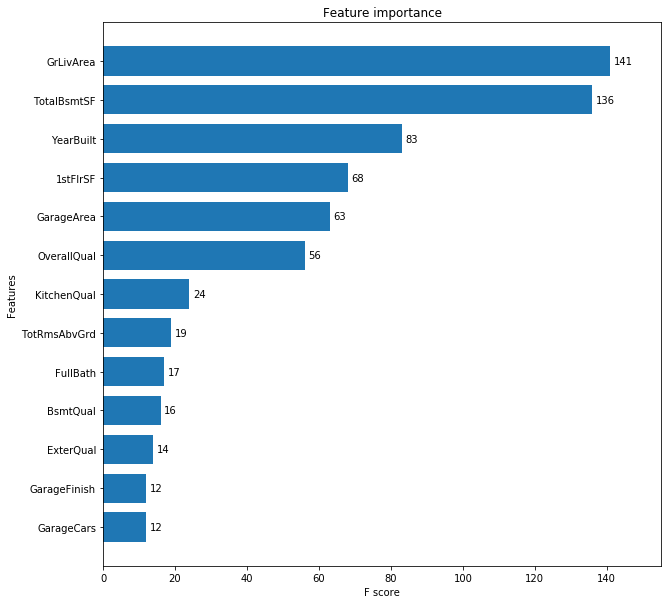

In [24]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for XGBoost Model is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_xgb.csv',index=False, header =1)

plt.rcParams["figure.figsize"] = (10, 10)
xgb.plot_importance(model, height = .75, grid = False)
plt.show()

Even better! And it got .16208 in Kaggle, which is comperable to random forest.

## LightGBM

Let's test the new hotness.

'RMSE for LightGBM Model is $29520.310860860624'

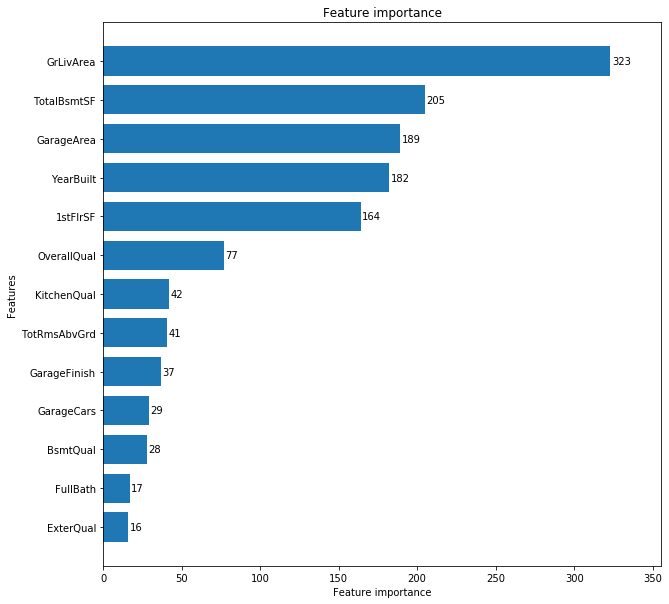

In [25]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for LightGBM Model is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_lgb.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

Slightly worse than random forest or XGBoost. Let's also sumbit to Kaggle to see how we're doing.

model4 got a score of 0.16308, which is slightly worse than decision tree. It's still quite good, though.

It's important to remember that the metrics on Kaggle, while helpful, are not the only meaningful statistics. They tell you how well your model generalized ONE TIME. But, on another set of test data, it might do better or worse. That's why internal metrics are helpful, to see how well you expect your model to generalize in general!

We could likely improve with some hyperparameter tuning, but there are some other big picture improvements we could work on, like:

1.  k-fold validation
2.  Better feature generation and selection
3.  Then maybe some hyperparameter tuning

# LightGBM Big Dump

We've done about all we can with my first preprocessing attempt. Let's see how LightGBM does with minimal preprocessing. Just let it decide what to do. I'm going to call this model the "Big Dump" model, because we're basically just dumping everything into LightGBM and letting it figure out the answer.

In [26]:
housing = pd.read_csv(f'{filepath}train.csv')
test = pd.read_csv(f'{filepath}test.csv')

train, valid = train_test_split(housing, test_size = .2)

In [27]:
# Ok, ordinal encoder doesn't work with NaN values. Crap. Let's do the missing value thing from above first

# Drop heavily empty columns
columns_to_drop = train.columns[train.isnull().sum() > len(train) * .15]
train.drop(columns_to_drop, inplace = True, axis = 1)
valid.drop(columns_to_drop, inplace = True, axis = 1)
test.drop(columns_to_drop, inplace = True, axis = 1)


# Also, drop the IDs
train.drop('Id', inplace = True, axis = 1)
valid.drop('Id', inplace = True, axis = 1)
test.drop('Id', inplace = True, axis = 1)


# Impute the rest

num_columns = train.select_dtypes(exclude=['object']).columns
cat_columns = train.select_dtypes(include=['object']).columns

# Impute Categorical Values
train.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent',verbose=0).fit_transform(test.loc[:, cat_columns])

# Impute Numerical Values
train.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(train.loc[:, num_columns])
valid.loc[:, num_columns] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(valid.loc[:, num_columns])
test.loc[:, num_columns.drop('SalePrice')] = SimpleImputer(missing_values = np.nan, strategy = 'mean',verbose=0).fit_transform(test.loc[:, num_columns.drop('SalePrice')])

In [28]:
# LightGBM says it can handle categorical features without the need for integer or one-hot, but it wasn't doing it for me. Piece of trash.
# LightGBM is supposed to do well with integer encoding, so let's try that
# Was having trouble, so I encoded each seperately, when I really should only encode based on the train data

code = OrdinalEncoder()

train.loc[:, cat_columns] = code.fit_transform(train.loc[:, cat_columns])
valid.loc[:, cat_columns] = code.fit_transform(valid.loc[:, cat_columns])
test.loc[:, cat_columns] = code.fit_transform(test.loc[:, cat_columns])

Ok, now let's try 

In [29]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]

X_test = test

In [30]:
# Also, scale the data!!
# Here, we're only scaling the domain, not the range. Should investigate whether it's worth it to scale the range as well


scaler = StandardScaler()
scaler.fit(X_train) 
X_train = pd.DataFrame(scaler.transform(X_train),columns = X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid),columns = X_valid.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

In [31]:
display(X_train)
display(X_valid)
display(X_test)

MSSubClass  MSZoning   LotArea    Street  LotShape  LandContour  \
0       0.076577 -0.050269  0.269261  0.058621  0.757588     0.312916   
1       0.076577 -0.050269 -0.084298  0.058621  0.757588     0.312916   
2      -0.160043 -0.050269 -0.099029  0.058621  0.757588     0.312916   
3       1.496300 -0.050269 -0.245240  0.058621  0.757588     0.312916   
4      -0.869904 -0.050269 -0.171398  0.058621  0.757588     0.312916   
...          ...       ...       ...       ...       ...          ...   
1163   -0.869904 -0.050269  0.276627  0.058621 -1.371192     0.312916   
1164    0.549818 -0.050269 -0.025831  0.058621 -1.371192     0.312916   
1165   -0.160043 -0.050269 -0.095530  0.058621  0.757588     0.312916   
1166    1.496300 -3.224021 -0.589408  0.058621 -1.371192     0.312916   
1167   -0.633284 -0.050269 -0.485734  0.058621  0.757588     0.312916   

      Utilities  LotConfig  LandSlope  Neighborhood  ...  OpenPorchSF  \
0     -0.029273   0.609065  -0.233475     -0.048606  ...    -0.067822   
1     -0.029273   0.609065   3.175266     -0.048606  ...     1.247849   
2     -0.029273   0.609065  -0.233475     -0.048606  ...    -0.710358   
3     -0.029273   0.609065  -0.233475      1.279402  ...     0.345238   
4     -0.029273   0.609065  -0.233475     -1.210614  ...     0.972476   
...         ...        ...        ...           ...  ...          ...   
1163  -0.029273  -1.229147  -0.233475     -0.878612  ...    -0.710358   
1164  -0.029273  -0.616410  -0.233475      0.283396  ...    -0.710358   
1165  -0.029273   0.609065  -0.233475      0.947400  ...    -0.710358   
1166  -0.029273   0.609065  -0.233475      1.445403  ...     1.064267   
1167  -0.029273  -1.841884   6.584006      0.781399  ...    -0.710358   

      EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   MiscVal    MoSold  \
0         -0.370680  -0.121498     3.174672 -0.071069 -0.115620  1.370737   
1         -0.370680  -0.121498     3.174672 -0.071069 -0.115620 -0.109634   
2         -0.370680  -0.121498    -0.266719 -0.071069 -0.115620  1.000644   
3         -0.370680  -0.121498    -0.266719 -0.071069 -0.115620  0.260459   
4         -0.370680  -0.121498    -0.266719 -0.071069 -0.115620 -1.219912   
...             ...        ...          ...       ...       ...       ...   
1163      -0.370680  -0.121498    -0.266719 -0.071069 -0.115620 -0.109634   
1164      -0.370680  -0.121498    -0.266719 -0.071069  1.462001  0.260459   
1165       0.300195  -0.121498     1.845458 -0.071069 -0.115620 -1.219912   
1166      -0.370680  -0.121498    -0.266719 -0.071069 -0.115620  1.740830   
1167       1.418321  -0.121498    -0.266719 -0.071069 -0.115620  2.110922   

        YrSold  SaleType  SaleCondition  
0     0.893787  0.318905       0.200971  
1     0.144366  0.318905       0.200971  
2     0.893787  0.318905       0.200971  
3     0.144366  0.318905       0.200971  
4     0.893787  0.318905      -3.438316  
...        ...       ...            ...  
1163  0.893787  0.318905       0.200971  
1164 -0.605054  0.318905       0.200971  
1165  1.643207  0.318905       0.200971  
1166 -0.605054 -0.965512       1.110793  
1167 -1.354475  0.318905      -3.438316  

[1168 rows x 73 columns]

MSSubClass  MSZoning   LotArea    Street  LotShape  LandContour  \
0      1.496300  1.536607 -0.228115  0.058621  0.047995     0.312916   
1     -0.869904 -0.050269 -0.163572  0.058621 -1.371192     0.312916   
2      0.076577 -0.050269 -0.317609  0.058621 -1.371192     0.312916   
3     -0.869904 -0.050269 -0.195153  0.058621  0.047995     0.312916   
4     -0.160043 -0.050269  0.169178  0.058621 -1.371192     0.312916   
..          ...       ...       ...       ...       ...          ...   
287   -0.869904 -0.050269 -0.321845  0.058621 -1.371192     0.312916   
288   -0.160043 -0.050269 -0.279307  0.058621  0.047995     0.312916   
289    3.152642  1.536607  0.269261  0.058621  0.047995     0.312916   
290   -0.869904 -0.050269  0.153434  0.058621 -1.371192     0.312916   
291    0.076577 -0.050269  0.114947  0.058621 -1.371192     0.312916   

     Utilities  LotConfig  LandSlope  Neighborhood  ...  OpenPorchSF  \
0    -0.029273  -0.003672  -0.233475      0.449397  ...    -0.251403   
1    -0.029273   0.609065  -0.233475     -0.878612  ...    -0.251403   
2    -0.029273  -1.229147  -0.233475     -1.376615  ...    -0.021926   
3    -0.029273   0.609065  -0.233475     -1.376615  ...     0.712402   
4    -0.029273  -0.616410  -0.233475     -0.214608  ...    -0.710358   
..         ...        ...        ...           ...  ...          ...   
287  -0.029273   0.609065  -0.233475     -1.376615  ...    -0.710358   
288  -0.029273  -1.841884  -0.233475     -1.210614  ...     2.961280   
289  -0.029273   0.609065  -0.233475      0.615398  ...     0.161656   
290  -0.029273   0.609065  -0.233475     -0.214608  ...    -0.710358   
291  -0.029273   0.609065  -0.233475      0.449397  ...    -0.389090   

     EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   MiscVal    MoSold  \
0        -0.370680  -0.121498    -0.266719 -0.071069 -0.115620  0.260459   
1        -0.370680  -0.121498    -0.266719 -0.071069 -0.115620  0.630552   
2        -0.370680  -0.121498    -0.266719 -0.071069 -0.115620 -0.109634   
3        -0.370680  -0.121498    -0.266719 -0.071069 -0.115620 -0.479726   
4        -0.370680  -0.121498    -0.266719 -0.071069 -0.115620 -0.109634   
..             ...        ...          ...       ...       ...       ...   
287      -0.370680  -0.121498    -0.266719 -0.071069 -0.115620 -0.479726   
288      -0.370680  -0.121498    -0.266719 -0.071069 -0.115620 -0.109634   
289      -0.370680  -0.121498    -0.266719 -0.071069 -0.115620  1.000644   
290       0.204356  -0.121498    -0.266719 -0.071069  1.777525  0.630552   
291      -0.370680  -0.121498    -0.266719 -0.071069 -0.115620  0.260459   

       YrSold  SaleType  SaleCondition  
0    0.144366 -1.607720      -0.708851  
1   -0.605054 -2.249928       0.200971  
2    0.144366 -1.607720      -0.708851  
3   -0.605054 -1.607720      -0.708851  
4    0.893787 -1.607720      -0.708851  
..        ...       ...            ...  
287  0.144366 -1.607720      -0.708851  
288 -0.605054 -1.607720      -0.708851  
289 -0.605054 -1.607720      -0.708851  
290 -0.605054 -1.607720      -0.708851  
291 -1.354475 -2.249928       0.200971  

[292 rows x 73 columns]

MSSubClass  MSZoning   LotArea    Street  LotShape  LandContour  \
0      -0.869904 -1.637145  0.087142  0.058621  0.757588     0.312916   
1      -0.869904 -0.050269  0.330673  0.058621 -1.371192     0.312916   
2       0.076577 -0.050269  0.290438  0.058621 -1.371192     0.312916   
3       0.076577 -0.050269 -0.064226  0.058621 -1.371192     0.312916   
4       1.496300 -0.050269 -0.522103  0.058621 -1.371192    -2.610970   
...          ...       ...       ...       ...       ...          ...   
1454    2.442781  1.536607 -0.804673  0.058621  0.757588     0.312916   
1455    2.442781  1.536607 -0.808540  0.058621  0.757588     0.312916   
1456   -0.869904 -0.050269  0.858526  0.058621  0.757588     0.312916   
1457    0.668128 -0.050269 -0.021596  0.058621  0.757588     0.312916   
1458    0.076577 -0.050269 -0.096543  0.058621  0.757588     0.312916   

      Utilities  LotConfig  LandSlope  Neighborhood  ...  OpenPorchSF  \
0     -0.029273   0.609065  -0.233475     -0.048606  ...    -0.710358   
1     -0.029273  -1.841884  -0.233475     -0.048606  ...    -0.159613   
2     -0.029273   0.609065  -0.233475     -0.712611  ...    -0.190210   
3     -0.029273   0.609065  -0.233475     -0.712611  ...    -0.159613   
4     -0.029273   0.609065  -0.233475      1.611404  ...     0.544118   
...         ...        ...        ...           ...  ...          ...   
1454  -0.029273   0.609065  -0.233475     -0.380609  ...    -0.710358   
1455  -0.029273   0.609065  -0.233475     -0.380609  ...    -0.343194   
1456  -0.029273   0.609065  -0.233475     -0.214608  ...    -0.710358   
1457  -0.029273   0.609065  -0.233475     -0.214608  ...    -0.220807   
1458  -0.029273   0.609065   3.175266     -0.214608  ...     0.023969   

      EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea    MiscVal    MoSold  \
0          -0.37068  -0.121498     1.918291 -0.071069  -0.115620 -0.109634   
1          -0.37068  -0.121498    -0.266719 -0.071069  39.324909 -0.109634   
2          -0.37068  -0.121498    -0.266719 -0.071069  -0.115620 -1.219912   
3          -0.37068  -0.121498    -0.266719 -0.071069  -0.115620 -0.109634   
4          -0.37068  -0.121498     2.355293 -0.071069  -0.115620 -1.960097   
...             ...        ...          ...       ...        ...       ...   
1454       -0.37068  -0.121498    -0.266719 -0.071069  -0.115620 -0.109634   
1455       -0.37068  -0.121498    -0.266719 -0.071069  -0.115620 -0.849819   
1456       -0.37068  -0.121498    -0.266719 -0.071069  -0.115620  1.000644   
1457       -0.37068  -0.121498    -0.266719 -0.071069   2.093049  0.260459   
1458       -0.37068  -0.121498    -0.266719 -0.071069  -0.115620  1.740830   

        YrSold  SaleType  SaleCondition  
0     1.643207  0.318905       0.200971  
1     1.643207  0.318905       0.200971  
2     1.643207  0.318905       0.200971  
3     1.643207  0.318905       0.200971  
4     1.643207  0.318905       0.200971  
...        ...       ...            ...  
1454 -1.354475  0.318905       0.200971  
1455 -1.354475  0.318905      -3.438316  
1456 -1.354475  0.318905      -3.438316  
1457 -1.354475  0.318905       0.200971  
1458 -1.354475  0.318905       0.200971  

[1459 rows x 73 columns]

In [32]:
model = lgb.LGBMRegressor()
model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for Big Dump LightGBM is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_lgbdump.csv',index=False, header =1)

'RMSE for Big Dump LightGBM is $24633.725632134105'

Excellent! That's a substantial improvement.

Kaggle: .14081
    
Well crap, this is better than even my attempt with all the encoding and stuff. What a waste of time! Still, that's probably because I dropped those other categorical columns.

Let's try tuning this bad boy.

## Grid Search the Big Dump Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   10.6s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:   12.4s finished


Best score reached: -30160.188804067984 with params: {'learning_rate': 0.1, 'num_leaves': 50} 



"RMSE for LightGBM Big Dump Grid Search with parameters {'learning_rate': 0.1, 'num_leaves': 50} is $25115.377772833115"

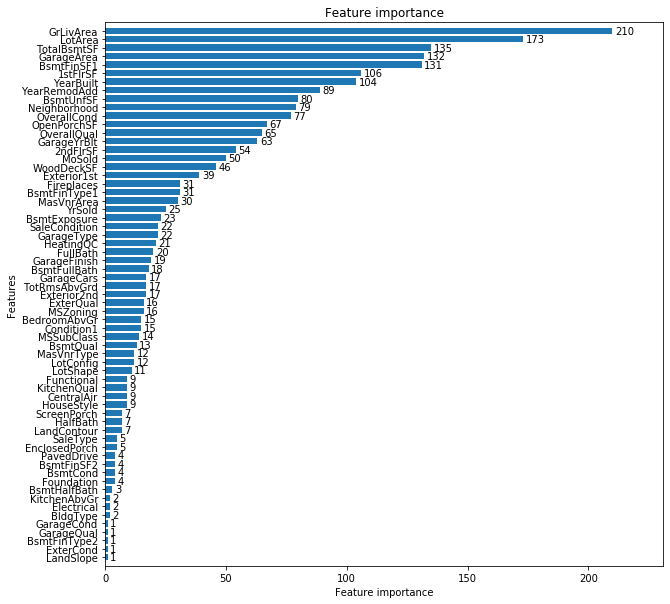

In [33]:
param_test = {'num_leaves': range(50, 60), 'learning_rate': [.1, .2, .3, .4, .5]}


model = lgb.LGBMRegressor(max_depth=-1, silent=True, n_jobs=3, n_estimators=5000, verbose = -1)


gs = GridSearchCV(
            estimator=model, 
            param_grid=param_test, 
            scoring='neg_root_mean_squared_error',
            #cv=5,
            refit=True,
            verbose=True,
            n_jobs = 3
            )

gs.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = 'rmse', verbose = False, early_stopping_rounds = 30)
print(f'Best score reached: {gs.best_score_} with params: {gs.best_params_} ')

model = lgb.LGBMRegressor(**gs.best_params_)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=30, verbose = False)

valid_pred = model.predict(X_valid)
error = np.sqrt(mse(valid_pred, y_valid))

print('')

display(f'RMSE for LightGBM Big Dump Grid Search with parameters {gs.best_params_} is ${error}')

test_pred = model.predict(X_test)

output = pd.DataFrame({'Id': test_id, 'SalePrice': test_pred})

output.to_csv(f'{sub_filepath}advhousesub_lgbdumpgs.csv',index=False, header =1)

lgb.plot_importance(model, height=.75, figsize = (10, 10), grid = False)
plt.show()

Slightly worse, but I only looked at a small number of hyperparameters. I'm sure there's a beautiful local minimum out there if I bothered to search for it! And we got Kaggle: .14039, which is a little better. Great!

Still, grid search is SLOW AS HECK. Next time I'll try a random search.

# Conclusion

Well, we've had a lot of fun, but what have we learned?  

1. We now have a model that can be used to predict housing price accuracy, Given that the mean house price is $181265, we are ending up with about a 35% error. That's not perfect, but it is still pretty good.
2. The most important information is area, then year, then quality. So if you want to buy cheap, buy small, old, and crappy. Which you probably knew before reading this notebook!
3. There is value in the many other features that I dropped from my first model (or at least, there is value in many of them). That's one benefit of a boosting model, like LightGBM. It is self correcting, so it can make sense of many features, and will weight lower the ones that are less important. However, it would be nearly impossible to explain how the model works, other than the feature importance it self reports.

## Future Research

I'm ready to move on to other research and other datasets, but what would I do if I were to continue with this dataset?  

1. Develop pipelines for all of my procedures. sklearn has some cool built in functions for creating pipelines.
2. Use dimensionality reduction to try to look for the most important features / linear combinations of features.
3. Use L1 / Lasso to select features